1.将线性插值修改为ODE插值，
2.显式引入物理能量特征，打破历史惯性。

具体操作： 在输入特征中（特别是 x_future），增加一列 “未来控制量累积值” (Cumulative Sum)。

--- 开始处理文件: 'Strawberry Greenhouse Environmental Control Dataset(version2).csv' ---
--> 正在加载和预处理数据...
--> 列名已清理: ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Pressure, MPa', 'Solution temperature, °C', 'Solution acidity, pH', 'Solution conductivity, ?S/cm', 'Heater', 'Lighting', 'Ventilation', 'Air circulation', 'Ground', 'Fog', 'Pump 1', 'Pump 2', 'Valve 1', 'Valve 2', 'Battery, V', 'Vcc, V', 'Version']
--> 正在执行基础线性插值...
--> [ODE Pro] 正在计算物理导数特征: ['Illumination, lx']...
    |-- 正在学习物理动力场 (Training Dynamics)...
    |-- 正在生成分钟级导数特征...
--> [成功] 已注入 1 个物理导数特征 (后缀 _Deriv)
--> [Energy] 正在构建能量累积特征 (Window=60min): ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']...
--> 最终数据维度: (31704, 21)

--- 正在构建物理基准模型 ---
--> 物理模型预测步长设定为: 120 分钟
---> 物理基准模型训练完成。

--- 正在构建与训练混合深度学习模型 (PyTorch) ---
--> 未来特征索引检查: [4, 5, 6, 7, 8, 2] (确认包含了天气列的索引)
--- 正在构建数据集: 输入过去 120 分钟，预测未来 120 分钟 ---


C:\Users\wokis\AppData\Local\Temp\ipykernel_30740\319249058.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')


--> 使用设备: cuda
--> 正在训练 混合模型(绝对值)...
--> 正在训练 混合模型(一阶差分)...

--- 性能对比 ---
[基准: 物理微分方程模型] MAE: 3.8811, RMSE: 5.6919, R2: 0.6350
[本文: 混合模型(绝对值)] MAE: 2.2636, RMSE: 2.9912, R2: 0.8992
[本文: 混合模型(一阶差分)] MAE: 2.1940, RMSE: 2.9568, R2: 0.9015


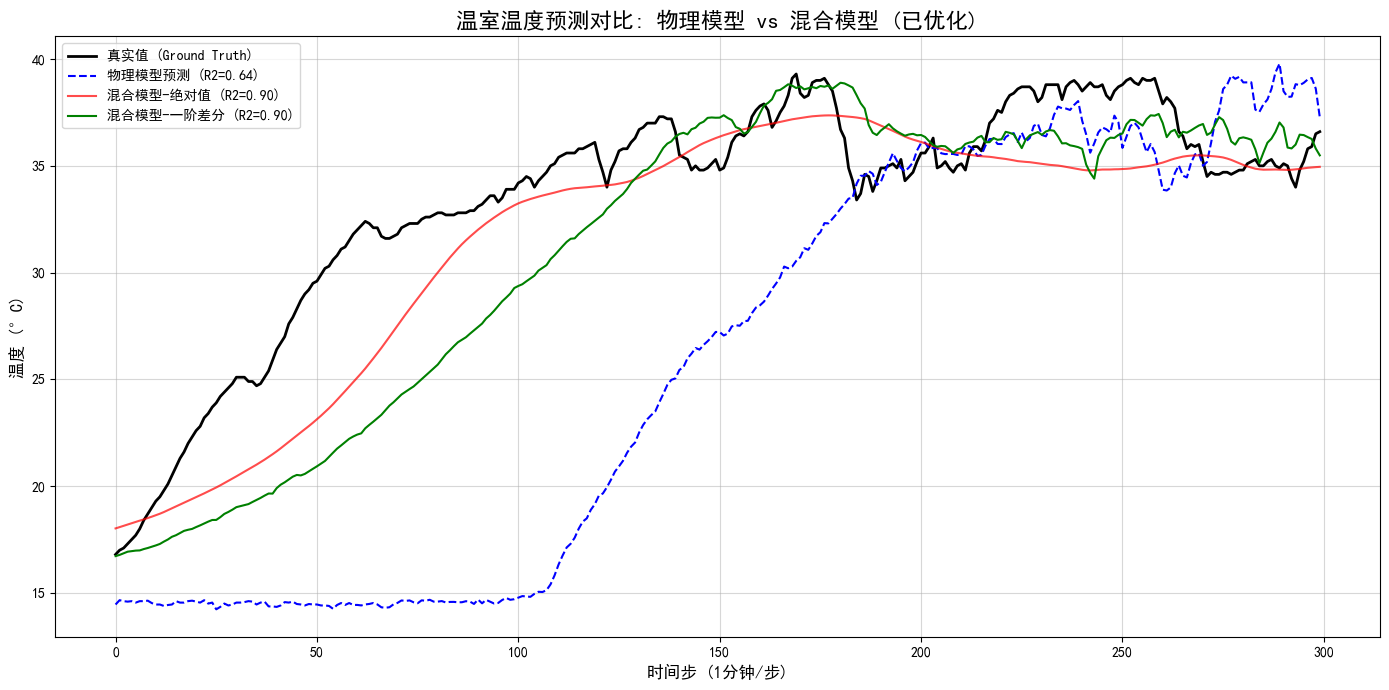


--- 结论分析 ---
1. 物理模型基于简化的线性假设，其 R2 分数为 0.6350。
2. 混合模型(绝对值方法) R2: 0.8992, MAE: 2.2636
3. 混合模型(一阶差分方法) R2: 0.9015, MAE: 2.1940


In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# === 辅助函数与类定义 (PyTorch) ===
# === [新版] 物理增强模块：Neural ODE 导数提取器 ===
class ODEF(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(ODEF, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(), # Softplus 比 Tanh 更适合拟合非负的物理量变化（如光照）
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, y):
        t_vec = torch.ones_like(y[..., :1]) * t
        cat_input = torch.cat([y, t_vec], dim=-1)
        return self.net(cat_input)

def generate_ode_derivatives(df, target_cols):
    """
    不改变原始数据的值，而是计算每分钟的'物理变化率'作为新特征
    """
    print(f"--> [ODE Pro] 正在计算物理导数特征: {target_cols}...")
    
    # 1. 准备训练数据 (仅使用非空的小时级数据)
    df_clean = df[target_cols].dropna()
    scaler = MinMaxScaler()
    data_np = scaler.fit_transform(df_clean.values)
    
    # 时间归一化 (以小时为单位)
    timestamps = (df_clean.index - df_clean.index[0]).total_seconds() / 3600.0
    t_tensor = torch.FloatTensor(timestamps).reshape(-1, 1)
    y_tensor = torch.FloatTensor(data_np)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t_tensor = t_tensor.to(device)
    y_tensor = y_tensor.to(device)
    
    # 2. 训练 ODE 网络拟合变化趋势
    ode_func = ODEF(input_dim=len(target_cols)).to(device)
    optimizer = torch.optim.Adam(ode_func.parameters(), lr=0.02) # 提高学习率
    
    ode_func.train()
    print("    |-- 正在学习物理动力场 (Training Dynamics)...")
    for epoch in range(300): # 增加迭代次数以捕捉细节
        optimizer.zero_grad()
        # 拟合目标：使得模型预测的导数 接近于 真实数据的差分
        # (y_{t+1} - y_t) / dt ~ f(t, y)
        dy_dt_target = (y_tensor[1:] - y_tensor[:-1]) / (t_tensor[1:] - t_tensor[:-1])
        t_mid = (t_tensor[1:] + t_tensor[:-1]) / 2
        y_mid = (y_tensor[1:] + y_tensor[:-1]) / 2
        
        pred_dy_dt = ode_func(t_mid, y_mid)
        loss = torch.mean((pred_dy_dt - dy_dt_target) ** 2)
        loss.backward()
        optimizer.step()
        
    # 3. 推断：生成每分钟的导数
    ode_func.eval()
    print("    |-- 正在生成分钟级导数特征...")
    
    # 创建完整的分钟级时间轴
    full_index = pd.date_range(start=df_clean.index[0], end=df_clean.index[-1], freq='1min')
    
    # 先对原始数据做简单的线性插值，作为 ODE 的输入状态 y
    # (因为我们需要知道当前大概是多少度，才能算出当前的变化率)
    df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')
    y_interp_np = scaler.transform(df_linear_temp.values)
    y_interp_tensor = torch.FloatTensor(y_interp_np).to(device)
    
    t_full_seconds = (full_index - df_clean.index[0]).total_seconds() / 3600.0
    t_full_tensor = torch.FloatTensor(t_full_seconds).reshape(-1, 1).to(device)
    
    with torch.no_grad():
        # 直接查询网络：在 t 时刻，状态为 y 时，变化率是多少？
        derivs_tensor = ode_func(t_full_tensor, y_interp_tensor)
    
    derivs_np = derivs_tensor.cpu().numpy()
    
    # 反归一化导数 (Scale back derivatives)
    # y = scaler * raw => dy = scaler * draw => draw = dy / scaler
    derivs_restored = derivs_np / (scaler.scale_ + 1e-8)
    
    # 创建 DataFrame，列名加后缀 "_Deriv"
    new_cols = [f"{c}_Deriv" for c in target_cols]
    df_derivs = pd.DataFrame(derivs_restored, index=full_index, columns=new_cols)
    
    return df_derivs

# 创建时间序列数据
def create_sequences(data, seq_length, forecast_horizon, future_indices, target_idx):
    xs_past, xs_future, ys, y_bases = [], [], [], []
    # 确保不越界：数据总长度 - (输入序列长度 + 预测距离)
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # 输入：从 i 开始，取 seq_length 个点
        x_p = data[i:(i + seq_length)]
        # 未来控制序列：从 seq_length 结束开始，取 forecast_horizon 个点
        x_f = data[i + seq_length : i + seq_length + forecast_horizon, future_indices]
        # 任务二：输出整个预测序列 [t+1, ..., t+horizon]
        y = data[i + seq_length : i + seq_length + forecast_horizon, target_idx]
        # 基准值：输入序列的最后一个目标值，用于计算差分
        y_base = data[i + seq_length - 1, target_idx]
        xs_past.append(x_p)
        xs_future.append(x_f)
        ys.append(y)
        y_bases.append(y_base)
    return np.array(xs_past), np.array(xs_future), np.array(ys), np.array(y_bases)

# 2. 对比混合模型 (Complex Past + Simple GRU Future)
class SimpleFutureModel(nn.Module):
    def __init__(self, input_dim, future_dim, forecast_horizon, hidden_dim=32):
        super(SimpleFutureModel, self).__init__()
        # 历史数据处理分支 (CNN + BiGRU + Attention)
        self.past_conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.past_bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.past_attention = nn.Linear(hidden_dim * 2, 1)
       
        # 未来控制序列处理分支 (仅使用单向 GRU)
        self.future_gru = nn.GRU(input_size=future_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
       
        # 融合层：历史特征 (hidden_dim * 2) + 未来特征 (hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2 + hidden_dim, forecast_horizon)
    
    def forward(self, x_past, x_future):
        # 处理历史序列 (Complex)
        x_p = x_past.permute(0, 2, 1)
        x_p = torch.relu(self.past_conv1(x_p))
        x_p = x_p.permute(0, 2, 1)
        gru_out_p, _ = self.past_bigru(x_p)
        weights_p = torch.softmax(self.past_attention(gru_out_p), dim=1)
        attended_p = torch.sum(weights_p * gru_out_p, dim=1)
       
        # 处理未来控制序列 (Simple GRU)
        _, h_n = self.future_gru(x_future)
        future_features = h_n[-1]  # 取最后一个时间步
       
        # 特征融合
        combined = torch.cat([attended_p, future_features], dim=1)
        output = self.fc(combined)
        return output

# 评估指标计算
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return mae, rmse, r2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 步骤 0: 初始设置 ---
filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'
print(f"--- 开始处理文件: '{filename}' ---")

try:
    # --- 步骤 1-3: 数据加载, 清洗, 重采样, 填充 ---
    print("--> 正在加载和预处理数据...")
    df = pd.read_csv(filename, encoding='latin1', sep=';', decimal=',', parse_dates=['Timestamp'], dayfirst=True, index_col='Timestamp')
    
    # === [修复] 全局列名清洗 ===
    # 去除列名中的引号和多余空格，统一命名规范，防止匹配失败
    df.columns = [c.replace('"', '').strip() for c in df.columns]
    print(f"--> 列名已清理: {list(df.columns)}")

    # 修复：在转换为数值之前处理开关量列，防止被 to_numeric 转为 NaN 而丢弃
    cols_to_binary = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    for col in cols_to_binary:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['on', 'yes', '1'] else 0)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    
    # === [修改点] 数据处理逻辑 ===
    print("--> 正在执行基础线性插值...")
    # 1. 基础线性插值 (保留最真实的数据骨架)
    df_resampled = df.resample('1min').mean().interpolate(method='linear').ffill().bfill()
    
    # 2. 生成 ODE 导数特征 (增强物理信息)
    outdoor_cols = [c for c in df.columns if 'Outdoor' in c or 'Solar' in c or 'Wind' in c or 'Illumination' in c]
    
    if outdoor_cols:
        try:
            # 计算导数
            df_derivs = generate_ode_derivatives(df, outdoor_cols)
            
            # 将导数特征合并到主表中
            # 注意：这就增加了特征维度，模型会自动利用这些新信息
            df_resampled = pd.concat([df_resampled, df_derivs], axis=1).dropna()
            
            print(f"--> [成功] 已注入 {len(outdoor_cols)} 个物理导数特征 (后缀 _Deriv)")
            
        except Exception as e:
            print(f"--> [警告] ODE 特征生成失败，仅使用原始数据: {e}")
    
    # === [新增] 能量累积特征 (Energy Accumulation) ===
    # 目的: 让模型感知"加热器开了多久"，解决起步慢/滞后问题
    control_cols = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    existing_control_cols = [c for c in control_cols if c in df_resampled.columns]
    
    if existing_control_cols:
        print(f"--> [Energy] 正在构建能量累积特征 (Window=60min): {existing_control_cols}...")
        for col in existing_control_cols:
            # 计算过去60分钟的累积开启时长 (即能量输入)
            df_resampled[f'{col}_Energy_60m'] = df_resampled[col].rolling(window=60, min_periods=1).sum()
        df_resampled.fillna(0, inplace=True)

    print(f"--> 最终数据维度: {df_resampled.shape}")
except Exception as e:
    print(f"处理数据时发生错误: {e}")
    sys.exit(1)

# --- 步骤 4: 物理基准模型构建 ---
print(f"\n--- 正在构建物理基准模型 ---")
# !!! 关键修改：将预测步长定义提前，确保物理模型和混合模型一致 !!!
# 1小时 = 60分钟 = 60 个 1分钟点
forecast_horizon = 120
print(f"--> 物理模型预测步长设定为: {forecast_horizon} 分钟")

physics_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar']
target_col = 'Temperature, °C'
available_physics_features = [col for col in physics_features if col in df_resampled.columns]

# 准备数据
data = df_resampled[available_physics_features].dropna()
if len(data) < forecast_horizon + 1: sys.exit("错误: 物理模型数据不足。")

# !!! 修正数据切片逻辑 !!!
# 输入 X: 从 0 到 总长度 - horizon
# 输出 y: 从 horizon 到 结尾
# 这样建立了 X_t -> y_{t+60} 的关系
X_physics = data.iloc[:-forecast_horizon].copy()
y_physics = data[target_col].iloc[forecast_horizon:].values

control_features = [col for col in ['Heater', 'Ventilation', 'Lighting'] if col in available_physics_features and col != target_col]

# 使用所有可用的物理特征（包含室外天气等）
feature_columns = available_physics_features

# --- 物理模型增强：加入未来控制量的均值 ---
# 计算未来 forecast_horizon 时间段内的控制变量均值
X_physics_augmented = X_physics.copy()
for col in control_features:
    # rolling(window).mean() 计算的是过去窗口的均值，shift(-window) 将其对齐到未来
    # 这样 X_physics_augmented[t] 就包含了 t 到 t+horizon 期间 heater 的平均开启率
    X_physics_augmented[f'Future_Mean_{col}'] = data[col].rolling(window=forecast_horizon).mean().shift(-forecast_horizon).iloc[:-forecast_horizon]

feature_columns = feature_columns + [f'Future_Mean_{col}' for col in control_features]
X_physics_features = X_physics_augmented[feature_columns].fillna(0).values

train_size = int(len(X_physics) * 0.8)
if train_size == 0: sys.exit("错误: 训练数据不足。")

X_train_phy, X_test_phy = X_physics_features[:train_size], X_physics_features[train_size:]
y_train_phy, y_test_phy = y_physics[:train_size], y_physics[train_size:]

physics_model = LinearRegression()
physics_model.fit(X_train_phy, y_train_phy)
y_pred_phy = physics_model.predict(X_test_phy)
print("---> 物理基准模型训练完成。")

# --- 步骤 5: 混合深度学习模型构建 (PyTorch) ---
print("\n--- 正在构建与训练混合深度学习模型 (PyTorch) ---")

df_hybrid = df_resampled.copy()

# 引入时间位置特征 (Time-of-Day Encoding)
hour_float = df_hybrid.index.hour + df_hybrid.index.minute / 60.0
df_hybrid['Hour_Sin'] = np.sin(2 * np.pi * hour_float / 24.0)
df_hybrid['Hour_Cos'] = np.cos(2 * np.pi * hour_float / 24.0)

input_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Hour_Sin', 'Hour_Cos']
# 自动添加导数特征
input_features += [c for c in df_hybrid.columns if '_Deriv' in c]
# 自动添加能量累积特征
input_features += [c for c in df_hybrid.columns if '_Energy' in c]
available_input_features = [f for f in input_features if f in df_hybrid.columns]
target_index = available_input_features.index(target_col)

# 获取控制变量的索引
control_indices = [available_input_features.index(col) for col in control_features]

# 将时间特征也视为“已知未来”的控制变量
time_indices = [available_input_features.index(col) for col in ['Hour_Sin', 'Hour_Cos'] if col in available_input_features]

# 1. 定义天气列
weather_cols = ['Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Illumination, lx']
weather_indices = [available_input_features.index(col) for col in weather_cols if col in available_input_features]

# 2. 加入未来索引
# 逻辑：未来预测 = f(未来控制 + 未来时间 + 未来天气预报)
future_indices = control_indices + time_indices + weather_indices
print(f"--> 未来特征索引检查: {future_indices} (确认包含了天气列的索引)")

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_hybrid[available_input_features])

# --- 数据集划分 (训练、验证、测试) ---
# --- 参数设置区域 ---
# 假设数据间隔是 5分钟 (df_resampled 是 5min 一行)
# 1. 设置输入窗口：比如看过去 2小时的数据来预测
# 2小时 = 120分钟 = 120 个 1分钟点
sequence_length = 120
print(f"--- 正在构建数据集: 输入过去 {sequence_length} 分钟，预测未来 {forecast_horizon} 分钟 ---")

# 原始训练数据
train_data_full = scaled_features[:train_size]
# 原始测试数据
test_data = scaled_features[train_size:]

# 将原始训练数据进一步划分为训练集和验证集 (80/20)
val_split_index = int(len(train_data_full) * 0.8)
train_data = train_data_full[:val_split_index]
val_data = train_data_full[val_split_index:]

# 创建序列
X_train_past, X_train_future, y_train, y_train_bases = create_sequences(train_data, sequence_length, forecast_horizon, future_indices, target_index)
X_val_past, X_val_future, y_val, y_val_bases = create_sequences(val_data, sequence_length, forecast_horizon, future_indices, target_index)
X_test_past, X_test_future, y_test_scaled, y_test_bases = create_sequences(test_data, sequence_length, forecast_horizon, future_indices, target_index)

if len(X_train_past) == 0 or len(X_val_past) == 0 or len(X_test_past) == 0:
    sys.exit("错误: 创建序列后数据不足以划分训练/验证/测试集。")

# 转换为PyTorch张量
X_train_past_tensor = torch.FloatTensor(X_train_past)
X_train_future_tensor = torch.FloatTensor(X_train_future)
y_train_tensor = torch.FloatTensor(y_train)
y_train_bases_tensor = torch.FloatTensor(y_train_bases).unsqueeze(1)

X_val_past_tensor = torch.FloatTensor(X_val_past)
X_val_future_tensor = torch.FloatTensor(X_val_future)
y_val_tensor = torch.FloatTensor(y_val)
y_val_bases_tensor = torch.FloatTensor(y_val_bases).unsqueeze(1)

X_test_past_tensor = torch.FloatTensor(X_test_past)
X_test_future_tensor = torch.FloatTensor(X_test_future)
y_test_bases_tensor = torch.FloatTensor(y_test_bases).unsqueeze(1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_past_tensor, X_train_future_tensor, y_train_tensor, y_train_bases_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_past_tensor, X_val_future_tensor, y_val_tensor, y_val_bases_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- 模型训练与早停机制 ---
# 新增: 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> 使用设备: {device}")

# --- 训练函数 ---
def train_and_predict(model, model_name, train_loader, val_loader, X_test_p, X_test_f, y_test_bases, scaler, target_idx, feat_cols, available_physics_features, predict_diff=False, lambda_trend=0.5):
    print(f"--> 正在训练 {model_name}...")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs, patience = 200, 10
    best_val_loss, epochs_no_improve = float('inf'), 0
    model_path = f"best_{model_name}.pth"
    
    for epoch in range(num_epochs):
        model.train()
        for b_Xp, b_Xf, b_y, b_base in train_loader:
            b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
            optimizer.zero_grad()
           
            pred = model(b_Xp, b_Xf)
            # 如果是差分模式，目标是 (未来值 - 当前基准值)
            target = (b_y - b_base) if predict_diff else b_y
           
            # 基础 MSE 损失
            loss_mse = criterion(pred, target)
           
            # 任务三：趋势惩罚 (Gradient Penalty)
            # 计算预测序列和目标序列的变化率（一阶差分）
            pred_diff = pred[:, 1:] - pred[:, :-1]
            target_diff = target[:, 1:] - target[:, :-1]
            loss_trend = criterion(pred_diff, target_diff)
           
            loss = loss_mse + lambda_trend * loss_trend
            loss.backward()
            optimizer.step()
       
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for b_Xp, b_Xf, b_y, b_base in val_loader:
                b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
                target = (b_y - b_base) if predict_diff else b_y
                val_loss += criterion(model(b_Xp, b_Xf), target).item()  # 验证集仅观察 MSE
       
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience: break
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        pred_tensor = model(X_test_p.to(device), X_test_f.to(device))
        # 仅取序列的最后一个点进行最终评估（对应 t+horizon）
        pred_final = pred_tensor[:, -1].unsqueeze(1)
       
        # 如果是差分模式，还原绝对值：预测的变化量 + 测试集基准值
        if predict_diff:
            pred_final = pred_final + torch.FloatTensor(y_test_bases).to(device).unsqueeze(1)
   
    pred_np = pred_final.cpu().numpy()
    dummy = np.zeros((len(pred_np), len(feat_cols)))
    dummy[:, target_idx] = pred_np.ravel()
    os.remove(model_path)
    return scaler.inverse_transform(dummy)[:, target_idx]

input_dim, future_dim = X_train_past_tensor.shape[2], len(future_indices)

# 实例化两个模型
model_abs = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)
model_diff = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)

# 1. 训练原方法（预测绝对值）
y_pred_abs = train_and_predict(model_abs, "混合模型(绝对值)", train_loader, val_loader,
                               X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=False)

# 2. 训练新方法（预测一阶差分）
y_pred_diff = train_and_predict(model_diff, "混合模型(一阶差分)", train_loader, val_loader,
                                X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=True)

# 获取真实值
dummy_true = np.zeros((len(y_test_scaled), len(available_input_features)))
dummy_true[:, target_index] = y_test_scaled[:, -1].ravel()  # 取序列最后一个点
y_test_hybrid = scaler.inverse_transform(dummy_true)[:, target_index]

# --- 步骤 6: 评估与可视化 ---
print("\n--- 性能对比 ---")

start_offset = sequence_length
end_offset = start_offset + len(y_test_hybrid)
y_test_phy_aligned = y_test_phy[start_offset:end_offset]
y_pred_phy_aligned = y_pred_phy[start_offset:end_offset]

min_len = min(len(y_test_hybrid), len(y_test_phy_aligned))

m1 = calculate_metrics(y_test_phy_aligned[:min_len], y_pred_phy_aligned[:min_len], "基准: 物理微分方程模型")
m2 = calculate_metrics(y_test_hybrid[:min_len], y_pred_abs[:min_len], "本文: 混合模型(绝对值)")
m3 = calculate_metrics(y_test_hybrid[:min_len], y_pred_diff[:min_len], "本文: 混合模型(一阶差分)")

plt.figure(figsize=(14, 7))
plot_len = min(300, min_len)
plt.plot(y_test_phy_aligned[:plot_len], label='真实值 (Ground Truth)', color='black', linewidth=2)
plt.plot(y_pred_phy_aligned[:plot_len], label=f'物理模型预测 (R2={m1[2]:.2f})', color='blue', linestyle='--')
plt.plot(y_pred_abs[:plot_len], label=f'混合模型-绝对值 (R2={m2[2]:.2f})', color='red', linewidth=1.5, alpha=0.7)
plt.plot(y_pred_diff[:plot_len], label=f'混合模型-一阶差分 (R2={m3[2]:.2f})', color='green', linewidth=1.5)
plt.title(f"温室温度预测对比: 物理模型 vs 混合模型 (已优化)", fontsize=16)
plt.xlabel("时间步 (1分钟/步)", fontsize=12)
plt.ylabel("温度 (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- 步骤 7: 输出结论文本 ---
print("\n--- 结论分析 ---")
print(f"1. 物理模型基于简化的线性假设，其 R2 分数为 {m1[2]:.4f}。")
print(f"2. 混合模型(绝对值方法) R2: {m2[2]:.4f}, MAE: {m2[0]:.4f}")
print(f"3. 混合模型(一阶差分方法) R2: {m3[2]:.4f}, MAE: {m3[0]:.4f}")

引入 Sobolev Loss (导数损失)，以便让模型在预测温度数值的同时，也能准确捕捉温度的变化率（斜率）。这对于预测温室中早晨快速升温等动态过程非常关键。

--- 开始处理文件: 'Strawberry Greenhouse Environmental Control Dataset(version2).csv' ---
--> 正在加载和预处理数据...
--> 列名已清理: ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Pressure, MPa', 'Solution temperature, °C', 'Solution acidity, pH', 'Solution conductivity, ?S/cm', 'Heater', 'Lighting', 'Ventilation', 'Air circulation', 'Ground', 'Fog', 'Pump 1', 'Pump 2', 'Valve 1', 'Valve 2', 'Battery, V', 'Vcc, V', 'Version']
--> 正在执行基础线性插值...
--> [ODE Pro] 正在计算物理导数特征: ['Illumination, lx']...
    |-- 正在学习物理动力场 (Training Dynamics)...
    |-- 正在生成分钟级导数特征...
--> [成功] 已注入 1 个物理导数特征 (后缀 _Deriv)
--> [Energy] 正在构建能量累积特征 (Window=60min): ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']...
--> 最终数据维度: (31704, 21)

--- 正在构建物理基准模型 ---
--> 物理模型预测步长设定为: 120 分钟
---> 物理基准模型训练完成。

--- 正在构建与训练混合深度学习模型 (PyTorch) ---
--> 未来特征索引检查: [4, 5, 6, 7, 8, 2] (确认包含了天气列的索引)
--- 正在构建数据集: 输入过去 120 分钟，预测未来 120 分钟 ---


C:\Users\wokis\AppData\Local\Temp\ipykernel_30740\3364587681.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')


--> 使用设备: cuda
--> 正在训练 混合模型(绝对值)...
--> 正在训练 混合模型(一阶差分)...

--- 性能对比 ---
[基准: 物理微分方程模型] MAE: 3.8811, RMSE: 5.6919, R2: 0.6350
[本文: 混合模型(绝对值)] MAE: 2.2678, RMSE: 3.1357, R2: 0.8892
[本文: 混合模型(一阶差分)] MAE: 2.3817, RMSE: 3.2068, R2: 0.8841


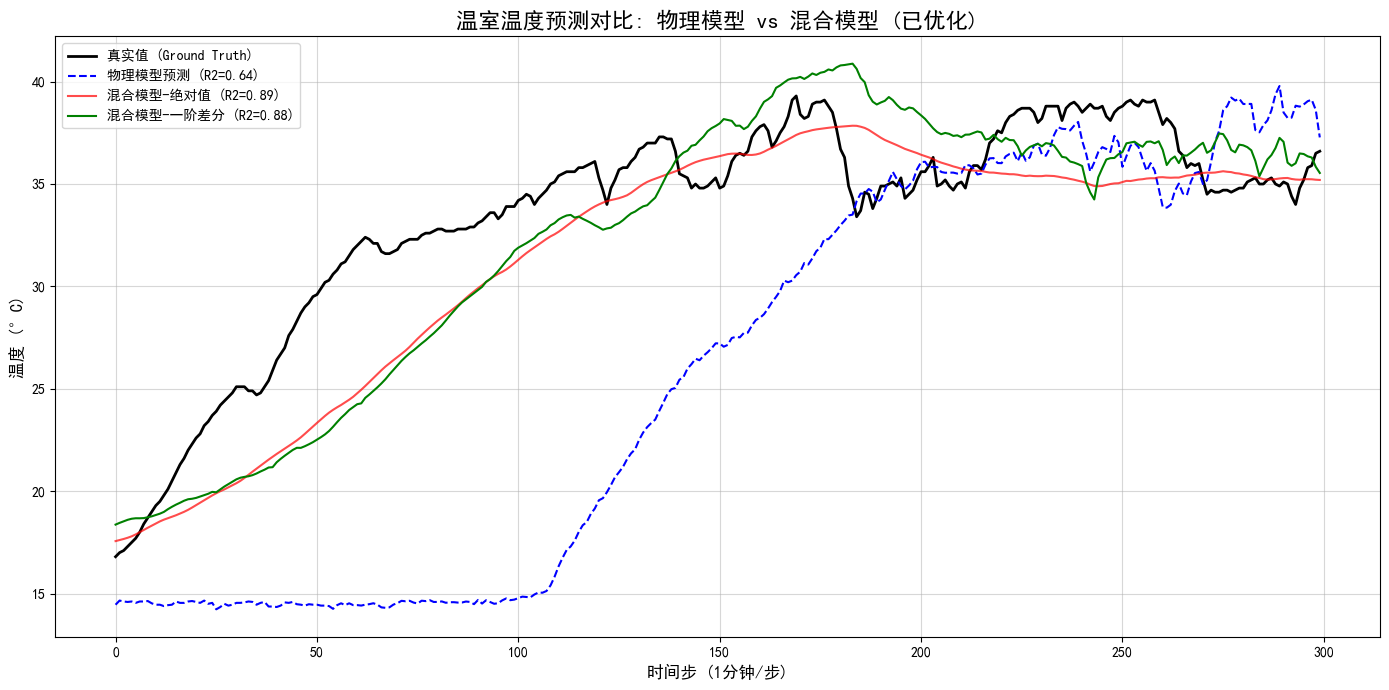


--- 结论分析 ---
1. 物理模型基于简化的线性假设，其 R2 分数为 0.6350。
2. 混合模型(绝对值方法) R2: 0.8892, MAE: 2.2678
3. 混合模型(一阶差分方法) R2: 0.8841, MAE: 2.3817


In [4]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# === 辅助函数与类定义 (PyTorch) ===
# === [新版] 物理增强模块：Neural ODE 导数提取器 ===
class ODEF(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(ODEF, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(), # Softplus 比 Tanh 更适合拟合非负的物理量变化（如光照）
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, y):
        t_vec = torch.ones_like(y[..., :1]) * t
        cat_input = torch.cat([y, t_vec], dim=-1)
        return self.net(cat_input)

def generate_ode_derivatives(df, target_cols):
    """
    不改变原始数据的值，而是计算每分钟的'物理变化率'作为新特征
    """
    print(f"--> [ODE Pro] 正在计算物理导数特征: {target_cols}...")
    
    # 1. 准备训练数据 (仅使用非空的小时级数据)
    df_clean = df[target_cols].dropna()
    scaler = MinMaxScaler()
    data_np = scaler.fit_transform(df_clean.values)
    
    # 时间归一化 (以小时为单位)
    timestamps = (df_clean.index - df_clean.index[0]).total_seconds() / 3600.0
    t_tensor = torch.FloatTensor(timestamps).reshape(-1, 1)
    y_tensor = torch.FloatTensor(data_np)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t_tensor = t_tensor.to(device)
    y_tensor = y_tensor.to(device)
    
    # 2. 训练 ODE 网络拟合变化趋势
    ode_func = ODEF(input_dim=len(target_cols)).to(device)
    optimizer = torch.optim.Adam(ode_func.parameters(), lr=0.02) # 提高学习率
    
    ode_func.train()
    print("    |-- 正在学习物理动力场 (Training Dynamics)...")
    for epoch in range(300): # 增加迭代次数以捕捉细节
        optimizer.zero_grad()
        # 拟合目标：使得模型预测的导数 接近于 真实数据的差分
        # (y_{t+1} - y_t) / dt ~ f(t, y)
        dy_dt_target = (y_tensor[1:] - y_tensor[:-1]) / (t_tensor[1:] - t_tensor[:-1])
        t_mid = (t_tensor[1:] + t_tensor[:-1]) / 2
        y_mid = (y_tensor[1:] + y_tensor[:-1]) / 2
        
        pred_dy_dt = ode_func(t_mid, y_mid)
        loss = torch.mean((pred_dy_dt - dy_dt_target) ** 2)
        loss.backward()
        optimizer.step()
        
    # 3. 推断：生成每分钟的导数
    ode_func.eval()
    print("    |-- 正在生成分钟级导数特征...")
    
    # 创建完整的分钟级时间轴
    full_index = pd.date_range(start=df_clean.index[0], end=df_clean.index[-1], freq='1min')
    
    # 先对原始数据做简单的线性插值，作为 ODE 的输入状态 y
    # (因为我们需要知道当前大概是多少度，才能算出当前的变化率)
    df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')
    y_interp_np = scaler.transform(df_linear_temp.values)
    y_interp_tensor = torch.FloatTensor(y_interp_np).to(device)
    
    t_full_seconds = (full_index - df_clean.index[0]).total_seconds() / 3600.0
    t_full_tensor = torch.FloatTensor(t_full_seconds).reshape(-1, 1).to(device)
    
    with torch.no_grad():
        # 直接查询网络：在 t 时刻，状态为 y 时，变化率是多少？
        derivs_tensor = ode_func(t_full_tensor, y_interp_tensor)
    
    derivs_np = derivs_tensor.cpu().numpy()
    
    # 反归一化导数 (Scale back derivatives)
    # y = scaler * raw => dy = scaler * draw => draw = dy / scaler
    derivs_restored = derivs_np / (scaler.scale_ + 1e-8)
    
    # 创建 DataFrame，列名加后缀 "_Deriv"
    new_cols = [f"{c}_Deriv" for c in target_cols]
    df_derivs = pd.DataFrame(derivs_restored, index=full_index, columns=new_cols)
    
    return df_derivs

# 创建时间序列数据
def create_sequences(data, seq_length, forecast_horizon, future_indices, target_idx):
    xs_past, xs_future, ys, y_bases = [], [], [], []
    # 确保不越界：数据总长度 - (输入序列长度 + 预测距离)
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # 输入：从 i 开始，取 seq_length 个点
        x_p = data[i:(i + seq_length)]
        # 未来控制序列：从 seq_length 结束开始，取 forecast_horizon 个点
        x_f = data[i + seq_length : i + seq_length + forecast_horizon, future_indices]
        # 任务二：输出整个预测序列 [t+1, ..., t+horizon]
        y = data[i + seq_length : i + seq_length + forecast_horizon, target_idx]
        # 基准值：输入序列的最后一个目标值，用于计算差分
        y_base = data[i + seq_length - 1, target_idx]
        xs_past.append(x_p)
        xs_future.append(x_f)
        ys.append(y)
        y_bases.append(y_base)
    return np.array(xs_past), np.array(xs_future), np.array(ys), np.array(y_bases)

# 2. 对比混合模型 (Complex Past + Simple GRU Future)
class SimpleFutureModel(nn.Module):
    def __init__(self, input_dim, future_dim, forecast_horizon, hidden_dim=32):
        super(SimpleFutureModel, self).__init__()
        # 历史数据处理分支 (CNN + BiGRU + Attention)
        self.past_conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.past_bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.past_attention = nn.Linear(hidden_dim * 2, 1)
       
        # 未来控制序列处理分支 (仅使用单向 GRU)
        self.future_gru = nn.GRU(input_size=future_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
       
        # 融合层：历史特征 (hidden_dim * 2) + 未来特征 (hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2 + hidden_dim, forecast_horizon)
    
    def forward(self, x_past, x_future):
        # 处理历史序列 (Complex)
        x_p = x_past.permute(0, 2, 1)
        x_p = torch.relu(self.past_conv1(x_p))
        x_p = x_p.permute(0, 2, 1)
        gru_out_p, _ = self.past_bigru(x_p)
        weights_p = torch.softmax(self.past_attention(gru_out_p), dim=1)
        attended_p = torch.sum(weights_p * gru_out_p, dim=1)
       
        # 处理未来控制序列 (Simple GRU)
        _, h_n = self.future_gru(x_future)
        future_features = h_n[-1]  # 取最后一个时间步
       
        # 特征融合
        combined = torch.cat([attended_p, future_features], dim=1)
        output = self.fc(combined)
        return output

# 评估指标计算
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return mae, rmse, r2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 步骤 0: 初始设置 ---
filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'
print(f"--- 开始处理文件: '{filename}' ---")

try:
    # --- 步骤 1-3: 数据加载, 清洗, 重采样, 填充 ---
    print("--> 正在加载和预处理数据...")
    df = pd.read_csv(filename, encoding='latin1', sep=';', decimal=',', parse_dates=['Timestamp'], dayfirst=True, index_col='Timestamp')
    
    # === [修复] 全局列名清洗 ===
    # 去除列名中的引号和多余空格，统一命名规范，防止匹配失败
    df.columns = [c.replace('"', '').strip() for c in df.columns]
    print(f"--> 列名已清理: {list(df.columns)}")

    # 修复：在转换为数值之前处理开关量列，防止被 to_numeric 转为 NaN 而丢弃
    cols_to_binary = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    for col in cols_to_binary:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['on', 'yes', '1'] else 0)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    
    # === [修改点] 数据处理逻辑 ===
    print("--> 正在执行基础线性插值...")
    # 1. 基础线性插值 (保留最真实的数据骨架)
    df_resampled = df.resample('1min').mean().interpolate(method='linear').ffill().bfill()
    
    # 2. 生成 ODE 导数特征 (增强物理信息)
    outdoor_cols = [c for c in df.columns if 'Outdoor' in c or 'Solar' in c or 'Wind' in c or 'Illumination' in c]
    
    if outdoor_cols:
        try:
            # 计算导数
            df_derivs = generate_ode_derivatives(df, outdoor_cols)
            
            # 将导数特征合并到主表中
            # 注意：这就增加了特征维度，模型会自动利用这些新信息
            df_resampled = pd.concat([df_resampled, df_derivs], axis=1).dropna()
            
            print(f"--> [成功] 已注入 {len(outdoor_cols)} 个物理导数特征 (后缀 _Deriv)")
            
        except Exception as e:
            print(f"--> [警告] ODE 特征生成失败，仅使用原始数据: {e}")
    
    # === [新增] 能量累积特征 (Energy Accumulation) ===
    # 目的: 让模型感知"加热器开了多久"，解决起步慢/滞后问题
    control_cols = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    existing_control_cols = [c for c in control_cols if c in df_resampled.columns]
    
    if existing_control_cols:
        print(f"--> [Energy] 正在构建能量累积特征 (Window=60min): {existing_control_cols}...")
        for col in existing_control_cols:
            # 计算过去60分钟的累积开启时长 (即能量输入)
            df_resampled[f'{col}_Energy_60m'] = df_resampled[col].rolling(window=60, min_periods=1).sum()
        df_resampled.fillna(0, inplace=True)

    print(f"--> 最终数据维度: {df_resampled.shape}")
except Exception as e:
    print(f"处理数据时发生错误: {e}")
    sys.exit(1)

# --- 步骤 4: 物理基准模型构建 ---
print(f"\n--- 正在构建物理基准模型 ---")
# !!! 关键修改：将预测步长定义提前，确保物理模型和混合模型一致 !!!
# 1小时 = 60分钟 = 60 个 1分钟点
forecast_horizon = 120
print(f"--> 物理模型预测步长设定为: {forecast_horizon} 分钟")

physics_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar']
target_col = 'Temperature, °C'
available_physics_features = [col for col in physics_features if col in df_resampled.columns]

# 准备数据
data = df_resampled[available_physics_features].dropna()
if len(data) < forecast_horizon + 1: sys.exit("错误: 物理模型数据不足。")

# !!! 修正数据切片逻辑 !!!
# 输入 X: 从 0 到 总长度 - horizon
# 输出 y: 从 horizon 到 结尾
# 这样建立了 X_t -> y_{t+60} 的关系
X_physics = data.iloc[:-forecast_horizon].copy()
y_physics = data[target_col].iloc[forecast_horizon:].values

control_features = [col for col in ['Heater', 'Ventilation', 'Lighting'] if col in available_physics_features and col != target_col]

# 使用所有可用的物理特征（包含室外天气等）
feature_columns = available_physics_features

# --- 物理模型增强：加入未来控制量的均值 ---
# 计算未来 forecast_horizon 时间段内的控制变量均值
X_physics_augmented = X_physics.copy()
for col in control_features:
    # rolling(window).mean() 计算的是过去窗口的均值，shift(-window) 将其对齐到未来
    # 这样 X_physics_augmented[t] 就包含了 t 到 t+horizon 期间 heater 的平均开启率
    X_physics_augmented[f'Future_Mean_{col}'] = data[col].rolling(window=forecast_horizon).mean().shift(-forecast_horizon).iloc[:-forecast_horizon]

feature_columns = feature_columns + [f'Future_Mean_{col}' for col in control_features]
X_physics_features = X_physics_augmented[feature_columns].fillna(0).values

train_size = int(len(X_physics) * 0.8)
if train_size == 0: sys.exit("错误: 训练数据不足。")

X_train_phy, X_test_phy = X_physics_features[:train_size], X_physics_features[train_size:]
y_train_phy, y_test_phy = y_physics[:train_size], y_physics[train_size:]

physics_model = LinearRegression()
physics_model.fit(X_train_phy, y_train_phy)
y_pred_phy = physics_model.predict(X_test_phy)
print("---> 物理基准模型训练完成。")

# --- 步骤 5: 混合深度学习模型构建 (PyTorch) ---
print("\n--- 正在构建与训练混合深度学习模型 (PyTorch) ---")

df_hybrid = df_resampled.copy()

# 引入时间位置特征 (Time-of-Day Encoding)
hour_float = df_hybrid.index.hour + df_hybrid.index.minute / 60.0
df_hybrid['Hour_Sin'] = np.sin(2 * np.pi * hour_float / 24.0)
df_hybrid['Hour_Cos'] = np.cos(2 * np.pi * hour_float / 24.0)

input_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Hour_Sin', 'Hour_Cos']
# 自动添加导数特征
input_features += [c for c in df_hybrid.columns if '_Deriv' in c]
# 自动添加能量累积特征
input_features += [c for c in df_hybrid.columns if '_Energy' in c]
available_input_features = [f for f in input_features if f in df_hybrid.columns]
target_index = available_input_features.index(target_col)

# 获取控制变量的索引
control_indices = [available_input_features.index(col) for col in control_features]

# 将时间特征也视为“已知未来”的控制变量
time_indices = [available_input_features.index(col) for col in ['Hour_Sin', 'Hour_Cos'] if col in available_input_features]

# 1. 定义天气列
weather_cols = ['Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Illumination, lx']
weather_indices = [available_input_features.index(col) for col in weather_cols if col in available_input_features]

# 2. 加入未来索引
# 逻辑：未来预测 = f(未来控制 + 未来时间 + 未来天气预报)
future_indices = control_indices + time_indices + weather_indices
print(f"--> 未来特征索引检查: {future_indices} (确认包含了天气列的索引)")

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_hybrid[available_input_features])

# --- 数据集划分 (训练、验证、测试) ---
# --- 参数设置区域 ---
# 假设数据间隔是 5分钟 (df_resampled 是 5min 一行)
# 1. 设置输入窗口：比如看过去 2小时的数据来预测
# 2小时 = 120分钟 = 120 个 1分钟点
sequence_length = 120
print(f"--- 正在构建数据集: 输入过去 {sequence_length} 分钟，预测未来 {forecast_horizon} 分钟 ---")

# 原始训练数据
train_data_full = scaled_features[:train_size]
# 原始测试数据
test_data = scaled_features[train_size:]

# 将原始训练数据进一步划分为训练集和验证集 (80/20)
val_split_index = int(len(train_data_full) * 0.8)
train_data = train_data_full[:val_split_index]
val_data = train_data_full[val_split_index:]

# 创建序列
X_train_past, X_train_future, y_train, y_train_bases = create_sequences(train_data, sequence_length, forecast_horizon, future_indices, target_index)
X_val_past, X_val_future, y_val, y_val_bases = create_sequences(val_data, sequence_length, forecast_horizon, future_indices, target_index)
X_test_past, X_test_future, y_test_scaled, y_test_bases = create_sequences(test_data, sequence_length, forecast_horizon, future_indices, target_index)

if len(X_train_past) == 0 or len(X_val_past) == 0 or len(X_test_past) == 0:
    sys.exit("错误: 创建序列后数据不足以划分训练/验证/测试集。")

# 转换为PyTorch张量
X_train_past_tensor = torch.FloatTensor(X_train_past)
X_train_future_tensor = torch.FloatTensor(X_train_future)
y_train_tensor = torch.FloatTensor(y_train)
y_train_bases_tensor = torch.FloatTensor(y_train_bases).unsqueeze(1)

X_val_past_tensor = torch.FloatTensor(X_val_past)
X_val_future_tensor = torch.FloatTensor(X_val_future)
y_val_tensor = torch.FloatTensor(y_val)
y_val_bases_tensor = torch.FloatTensor(y_val_bases).unsqueeze(1)

X_test_past_tensor = torch.FloatTensor(X_test_past)
X_test_future_tensor = torch.FloatTensor(X_test_future)
y_test_bases_tensor = torch.FloatTensor(y_test_bases).unsqueeze(1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_past_tensor, X_train_future_tensor, y_train_tensor, y_train_bases_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_past_tensor, X_val_future_tensor, y_val_tensor, y_val_bases_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- 模型训练与早停机制 ---
# 新增: 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> 使用设备: {device}")

# --- 训练函数 ---
class SobolevLoss(nn.Module):
    def __init__(self, lambda_deriv=0.5):
        """
        lambda_deriv: 导数项的权重。权重越大，模型越关注变化的趋势（升温速度）。
        """
        super().__init__()
        self.lambda_deriv = lambda_deriv
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        # 1. 基础的值误差 (Value Loss)
        loss_value = self.mse(pred, target)
        
        # 2. 导数误差 (Derivative Loss) - 计算时间步之间的差分
        # pred shape: [batch, seq_len]
        pred_diff = pred[:, 1:] - pred[:, :-1]
        target_diff = target[:, 1:] - target[:, :-1]
        
        loss_deriv = self.mse(pred_diff, target_diff)
        
        return loss_value + self.lambda_deriv * loss_deriv

def train_and_predict(model, model_name, train_loader, val_loader, X_test_p, X_test_f, y_test_bases, scaler, target_idx, feat_cols, available_physics_features, predict_diff=False, lambda_trend=1.0):
    print(f"--> 正在训练 {model_name}...")
    criterion = SobolevLoss(lambda_deriv=lambda_trend) # 强迫模型学习“变化率”
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs, patience = 200, 10
    best_val_loss, epochs_no_improve = float('inf'), 0
    model_path = f"best_{model_name}.pth"
    
    for epoch in range(num_epochs):
        model.train()
        for b_Xp, b_Xf, b_y, b_base in train_loader:
            b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
            optimizer.zero_grad()
           
            pred = model(b_Xp, b_Xf)
            # 如果是差分模式，目标是 (未来值 - 当前基准值)
            target = (b_y - b_base) if predict_diff else b_y
           
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
       
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for b_Xp, b_Xf, b_y, b_base in val_loader:
                b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
                target = (b_y - b_base) if predict_diff else b_y
                val_loss += criterion(model(b_Xp, b_Xf), target).item()  # 验证集仅观察 MSE
       
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience: break
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        pred_tensor = model(X_test_p.to(device), X_test_f.to(device))
        # 仅取序列的最后一个点进行最终评估（对应 t+horizon）
        pred_final = pred_tensor[:, -1].unsqueeze(1)
       
        # 如果是差分模式，还原绝对值：预测的变化量 + 测试集基准值
        if predict_diff:
            pred_final = pred_final + torch.FloatTensor(y_test_bases).to(device).unsqueeze(1)
   
    pred_np = pred_final.cpu().numpy()
    dummy = np.zeros((len(pred_np), len(feat_cols)))
    dummy[:, target_idx] = pred_np.ravel()
    os.remove(model_path)
    return scaler.inverse_transform(dummy)[:, target_idx]

input_dim, future_dim = X_train_past_tensor.shape[2], len(future_indices)

# 实例化两个模型
model_abs = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)
model_diff = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)

# 1. 训练原方法（预测绝对值）
y_pred_abs = train_and_predict(model_abs, "混合模型(绝对值)", train_loader, val_loader,
                               X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=False)

# 2. 训练新方法（预测一阶差分）
y_pred_diff = train_and_predict(model_diff, "混合模型(一阶差分)", train_loader, val_loader,
                                X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=True)

# 获取真实值
dummy_true = np.zeros((len(y_test_scaled), len(available_input_features)))
dummy_true[:, target_index] = y_test_scaled[:, -1].ravel()  # 取序列最后一个点
y_test_hybrid = scaler.inverse_transform(dummy_true)[:, target_index]

# --- 步骤 6: 评估与可视化 ---
print("\n--- 性能对比 ---")

start_offset = sequence_length
end_offset = start_offset + len(y_test_hybrid)
y_test_phy_aligned = y_test_phy[start_offset:end_offset]
y_pred_phy_aligned = y_pred_phy[start_offset:end_offset]

min_len = min(len(y_test_hybrid), len(y_test_phy_aligned))

m1 = calculate_metrics(y_test_phy_aligned[:min_len], y_pred_phy_aligned[:min_len], "基准: 物理微分方程模型")
m2 = calculate_metrics(y_test_hybrid[:min_len], y_pred_abs[:min_len], "本文: 混合模型(绝对值)")
m3 = calculate_metrics(y_test_hybrid[:min_len], y_pred_diff[:min_len], "本文: 混合模型(一阶差分)")

plt.figure(figsize=(14, 7))
plot_len = min(300, min_len)
plt.plot(y_test_phy_aligned[:plot_len], label='真实值 (Ground Truth)', color='black', linewidth=2)
plt.plot(y_pred_phy_aligned[:plot_len], label=f'物理模型预测 (R2={m1[2]:.2f})', color='blue', linestyle='--')
plt.plot(y_pred_abs[:plot_len], label=f'混合模型-绝对值 (R2={m2[2]:.2f})', color='red', linewidth=1.5, alpha=0.7)
plt.plot(y_pred_diff[:plot_len], label=f'混合模型-一阶差分 (R2={m3[2]:.2f})', color='green', linewidth=1.5)
plt.title(f"温室温度预测对比: 物理模型 vs 混合模型 (已优化)", fontsize=16)
plt.xlabel("时间步 (1分钟/步)", fontsize=12)
plt.ylabel("温度 (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- 步骤 7: 输出结论文本 ---
print("\n--- 结论分析 ---")
print(f"1. 物理模型基于简化的线性假设，其 R2 分数为 {m1[2]:.4f}。")
print(f"2. 混合模型(绝对值方法) R2: {m2[2]:.4f}, MAE: {m2[0]:.4f}")
print(f"3. 混合模型(一阶差分方法) R2: {m3[2]:.4f}, MAE: {m3[0]:.4f}")

--- 开始处理文件: 'Strawberry Greenhouse Environmental Control Dataset(version2).csv' ---
--> 正在加载和预处理数据...
--> 列名已清理: ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Pressure, MPa', 'Solution temperature, °C', 'Solution acidity, pH', 'Solution conductivity, ?S/cm', 'Heater', 'Lighting', 'Ventilation', 'Air circulation', 'Ground', 'Fog', 'Pump 1', 'Pump 2', 'Valve 1', 'Valve 2', 'Battery, V', 'Vcc, V', 'Version']
--> 正在执行基础线性插值...
--> [ODE Pro] 正在计算物理导数特征: ['Illumination, lx']...
    |-- 正在学习物理动力场 (Training Dynamics)...
    |-- 正在生成分钟级导数特征...
--> [成功] 已注入 1 个物理导数特征 (后缀 _Deriv)
--> [Energy] 正在构建能量累积特征 (Window=60min): ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']...
--> 最终数据维度: (31704, 21)

--- 正在构建物理基准模型 ---
--> 物理模型预测步长设定为: 120 分钟
---> 物理基准模型训练完成。

--- 正在构建与训练混合深度学习模型 (PyTorch) ---
--> 未来特征索引检查: [4, 5, 6, 7, 8, 2] (确认包含了天气列的索引)
--- 正在构建数据集: 输入过去 120 分钟，预测未来 120 分钟 ---


C:\Users\wokis\AppData\Local\Temp\ipykernel_30740\3364587681.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')


--> 使用设备: cuda
--> 正在训练 混合模型(绝对值)...
--> 正在训练 混合模型(一阶差分)...

--- 性能对比 ---
[基准: 物理微分方程模型] MAE: 3.8811, RMSE: 5.6919, R2: 0.6350
[本文: 混合模型(绝对值)] MAE: 2.4797, RMSE: 3.3395, R2: 0.8744
[本文: 混合模型(一阶差分)] MAE: 2.2813, RMSE: 3.0742, R2: 0.8935


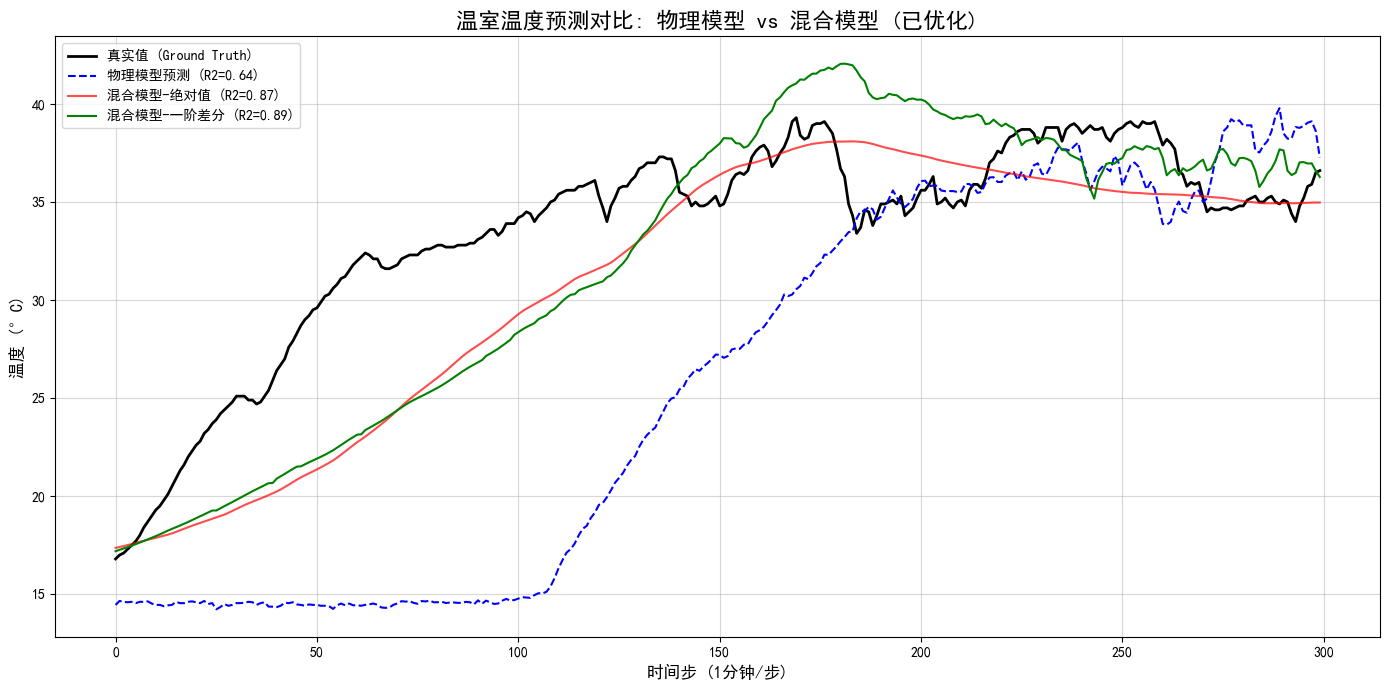


--- 结论分析 ---
1. 物理模型基于简化的线性假设，其 R2 分数为 0.6350。
2. 混合模型(绝对值方法) R2: 0.8744, MAE: 2.4797
3. 混合模型(一阶差分方法) R2: 0.8935, MAE: 2.2813


In [5]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# === 辅助函数与类定义 (PyTorch) ===
# === [新版] 物理增强模块：Neural ODE 导数提取器 ===
class ODEF(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(ODEF, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(), # Softplus 比 Tanh 更适合拟合非负的物理量变化（如光照）
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, y):
        t_vec = torch.ones_like(y[..., :1]) * t
        cat_input = torch.cat([y, t_vec], dim=-1)
        return self.net(cat_input)

def generate_ode_derivatives(df, target_cols):
    """
    不改变原始数据的值，而是计算每分钟的'物理变化率'作为新特征
    """
    print(f"--> [ODE Pro] 正在计算物理导数特征: {target_cols}...")
    
    # 1. 准备训练数据 (仅使用非空的小时级数据)
    df_clean = df[target_cols].dropna()
    scaler = MinMaxScaler()
    data_np = scaler.fit_transform(df_clean.values)
    
    # 时间归一化 (以小时为单位)
    timestamps = (df_clean.index - df_clean.index[0]).total_seconds() / 3600.0
    t_tensor = torch.FloatTensor(timestamps).reshape(-1, 1)
    y_tensor = torch.FloatTensor(data_np)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t_tensor = t_tensor.to(device)
    y_tensor = y_tensor.to(device)
    
    # 2. 训练 ODE 网络拟合变化趋势
    ode_func = ODEF(input_dim=len(target_cols)).to(device)
    optimizer = torch.optim.Adam(ode_func.parameters(), lr=0.02) # 提高学习率
    
    ode_func.train()
    print("    |-- 正在学习物理动力场 (Training Dynamics)...")
    for epoch in range(300): # 增加迭代次数以捕捉细节
        optimizer.zero_grad()
        # 拟合目标：使得模型预测的导数 接近于 真实数据的差分
        # (y_{t+1} - y_t) / dt ~ f(t, y)
        dy_dt_target = (y_tensor[1:] - y_tensor[:-1]) / (t_tensor[1:] - t_tensor[:-1])
        t_mid = (t_tensor[1:] + t_tensor[:-1]) / 2
        y_mid = (y_tensor[1:] + y_tensor[:-1]) / 2
        
        pred_dy_dt = ode_func(t_mid, y_mid)
        loss = torch.mean((pred_dy_dt - dy_dt_target) ** 2)
        loss.backward()
        optimizer.step()
        
    # 3. 推断：生成每分钟的导数
    ode_func.eval()
    print("    |-- 正在生成分钟级导数特征...")
    
    # 创建完整的分钟级时间轴
    full_index = pd.date_range(start=df_clean.index[0], end=df_clean.index[-1], freq='1min')
    
    # 先对原始数据做简单的线性插值，作为 ODE 的输入状态 y
    # (因为我们需要知道当前大概是多少度，才能算出当前的变化率)
    df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')
    y_interp_np = scaler.transform(df_linear_temp.values)
    y_interp_tensor = torch.FloatTensor(y_interp_np).to(device)
    
    t_full_seconds = (full_index - df_clean.index[0]).total_seconds() / 3600.0
    t_full_tensor = torch.FloatTensor(t_full_seconds).reshape(-1, 1).to(device)
    
    with torch.no_grad():
        # 直接查询网络：在 t 时刻，状态为 y 时，变化率是多少？
        derivs_tensor = ode_func(t_full_tensor, y_interp_tensor)
    
    derivs_np = derivs_tensor.cpu().numpy()
    
    # 反归一化导数 (Scale back derivatives)
    # y = scaler * raw => dy = scaler * draw => draw = dy / scaler
    derivs_restored = derivs_np / (scaler.scale_ + 1e-8)
    
    # 创建 DataFrame，列名加后缀 "_Deriv"
    new_cols = [f"{c}_Deriv" for c in target_cols]
    df_derivs = pd.DataFrame(derivs_restored, index=full_index, columns=new_cols)
    
    return df_derivs

# 创建时间序列数据
def create_sequences(data, seq_length, forecast_horizon, future_indices, target_idx):
    xs_past, xs_future, ys, y_bases = [], [], [], []
    # 确保不越界：数据总长度 - (输入序列长度 + 预测距离)
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # 输入：从 i 开始，取 seq_length 个点
        x_p = data[i:(i + seq_length)]
        # 未来控制序列：从 seq_length 结束开始，取 forecast_horizon 个点
        x_f = data[i + seq_length : i + seq_length + forecast_horizon, future_indices]
        # 任务二：输出整个预测序列 [t+1, ..., t+horizon]
        y = data[i + seq_length : i + seq_length + forecast_horizon, target_idx]
        # 基准值：输入序列的最后一个目标值，用于计算差分
        y_base = data[i + seq_length - 1, target_idx]
        xs_past.append(x_p)
        xs_future.append(x_f)
        ys.append(y)
        y_bases.append(y_base)
    return np.array(xs_past), np.array(xs_future), np.array(ys), np.array(y_bases)

# 2. 对比混合模型 (Complex Past + Simple GRU Future)
class SimpleFutureModel(nn.Module):
    def __init__(self, input_dim, future_dim, forecast_horizon, hidden_dim=32):
        super(SimpleFutureModel, self).__init__()
        # 历史数据处理分支 (CNN + BiGRU + Attention)
        self.past_conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.past_bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.past_attention = nn.Linear(hidden_dim * 2, 1)
       
        # 未来控制序列处理分支 (仅使用单向 GRU)
        self.future_gru = nn.GRU(input_size=future_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
       
        # 融合层：历史特征 (hidden_dim * 2) + 未来特征 (hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2 + hidden_dim, forecast_horizon)
    
    def forward(self, x_past, x_future):
        # 处理历史序列 (Complex)
        x_p = x_past.permute(0, 2, 1)
        x_p = torch.relu(self.past_conv1(x_p))
        x_p = x_p.permute(0, 2, 1)
        gru_out_p, _ = self.past_bigru(x_p)
        weights_p = torch.softmax(self.past_attention(gru_out_p), dim=1)
        attended_p = torch.sum(weights_p * gru_out_p, dim=1)
       
        # 处理未来控制序列 (Simple GRU)
        _, h_n = self.future_gru(x_future)
        future_features = h_n[-1]  # 取最后一个时间步
       
        # 特征融合
        combined = torch.cat([attended_p, future_features], dim=1)
        output = self.fc(combined)
        return output

# 评估指标计算
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return mae, rmse, r2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 步骤 0: 初始设置 ---
filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'
print(f"--- 开始处理文件: '{filename}' ---")

try:
    # --- 步骤 1-3: 数据加载, 清洗, 重采样, 填充 ---
    print("--> 正在加载和预处理数据...")
    df = pd.read_csv(filename, encoding='latin1', sep=';', decimal=',', parse_dates=['Timestamp'], dayfirst=True, index_col='Timestamp')
    
    # === [修复] 全局列名清洗 ===
    # 去除列名中的引号和多余空格，统一命名规范，防止匹配失败
    df.columns = [c.replace('"', '').strip() for c in df.columns]
    print(f"--> 列名已清理: {list(df.columns)}")

    # 修复：在转换为数值之前处理开关量列，防止被 to_numeric 转为 NaN 而丢弃
    cols_to_binary = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    for col in cols_to_binary:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['on', 'yes', '1'] else 0)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    
    # === [修改点] 数据处理逻辑 ===
    print("--> 正在执行基础线性插值...")
    # 1. 基础线性插值 (保留最真实的数据骨架)
    df_resampled = df.resample('1min').mean().interpolate(method='linear').ffill().bfill()
    
    # 2. 生成 ODE 导数特征 (增强物理信息)
    outdoor_cols = [c for c in df.columns if 'Outdoor' in c or 'Solar' in c or 'Wind' in c or 'Illumination' in c]
    
    if outdoor_cols:
        try:
            # 计算导数
            df_derivs = generate_ode_derivatives(df, outdoor_cols)
            
            # 将导数特征合并到主表中
            # 注意：这就增加了特征维度，模型会自动利用这些新信息
            df_resampled = pd.concat([df_resampled, df_derivs], axis=1).dropna()
            
            print(f"--> [成功] 已注入 {len(outdoor_cols)} 个物理导数特征 (后缀 _Deriv)")
            
        except Exception as e:
            print(f"--> [警告] ODE 特征生成失败，仅使用原始数据: {e}")
    
    # === [新增] 能量累积特征 (Energy Accumulation) ===
    # 目的: 让模型感知"加热器开了多久"，解决起步慢/滞后问题
    control_cols = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    existing_control_cols = [c for c in control_cols if c in df_resampled.columns]
    
    if existing_control_cols:
        print(f"--> [Energy] 正在构建能量累积特征 (Window=60min): {existing_control_cols}...")
        for col in existing_control_cols:
            # 计算过去60分钟的累积开启时长 (即能量输入)
            df_resampled[f'{col}_Energy_60m'] = df_resampled[col].rolling(window=60, min_periods=1).sum()
        df_resampled.fillna(0, inplace=True)

    print(f"--> 最终数据维度: {df_resampled.shape}")
except Exception as e:
    print(f"处理数据时发生错误: {e}")
    sys.exit(1)

# --- 步骤 4: 物理基准模型构建 ---
print(f"\n--- 正在构建物理基准模型 ---")
# !!! 关键修改：将预测步长定义提前，确保物理模型和混合模型一致 !!!
# 1小时 = 60分钟 = 60 个 1分钟点
forecast_horizon = 120
print(f"--> 物理模型预测步长设定为: {forecast_horizon} 分钟")

physics_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar']
target_col = 'Temperature, °C'
available_physics_features = [col for col in physics_features if col in df_resampled.columns]

# 准备数据
data = df_resampled[available_physics_features].dropna()
if len(data) < forecast_horizon + 1: sys.exit("错误: 物理模型数据不足。")

# !!! 修正数据切片逻辑 !!!
# 输入 X: 从 0 到 总长度 - horizon
# 输出 y: 从 horizon 到 结尾
# 这样建立了 X_t -> y_{t+60} 的关系
X_physics = data.iloc[:-forecast_horizon].copy()
y_physics = data[target_col].iloc[forecast_horizon:].values

control_features = [col for col in ['Heater', 'Ventilation', 'Lighting'] if col in available_physics_features and col != target_col]

# 使用所有可用的物理特征（包含室外天气等）
feature_columns = available_physics_features

# --- 物理模型增强：加入未来控制量的均值 ---
# 计算未来 forecast_horizon 时间段内的控制变量均值
X_physics_augmented = X_physics.copy()
for col in control_features:
    # rolling(window).mean() 计算的是过去窗口的均值，shift(-window) 将其对齐到未来
    # 这样 X_physics_augmented[t] 就包含了 t 到 t+horizon 期间 heater 的平均开启率
    X_physics_augmented[f'Future_Mean_{col}'] = data[col].rolling(window=forecast_horizon).mean().shift(-forecast_horizon).iloc[:-forecast_horizon]

feature_columns = feature_columns + [f'Future_Mean_{col}' for col in control_features]
X_physics_features = X_physics_augmented[feature_columns].fillna(0).values

train_size = int(len(X_physics) * 0.8)
if train_size == 0: sys.exit("错误: 训练数据不足。")

X_train_phy, X_test_phy = X_physics_features[:train_size], X_physics_features[train_size:]
y_train_phy, y_test_phy = y_physics[:train_size], y_physics[train_size:]

physics_model = LinearRegression()
physics_model.fit(X_train_phy, y_train_phy)
y_pred_phy = physics_model.predict(X_test_phy)
print("---> 物理基准模型训练完成。")

# --- 步骤 5: 混合深度学习模型构建 (PyTorch) ---
print("\n--- 正在构建与训练混合深度学习模型 (PyTorch) ---")

df_hybrid = df_resampled.copy()

# 引入时间位置特征 (Time-of-Day Encoding)
hour_float = df_hybrid.index.hour + df_hybrid.index.minute / 60.0
df_hybrid['Hour_Sin'] = np.sin(2 * np.pi * hour_float / 24.0)
df_hybrid['Hour_Cos'] = np.cos(2 * np.pi * hour_float / 24.0)

input_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Hour_Sin', 'Hour_Cos']
# 自动添加导数特征
input_features += [c for c in df_hybrid.columns if '_Deriv' in c]
# 自动添加能量累积特征
input_features += [c for c in df_hybrid.columns if '_Energy' in c]
available_input_features = [f for f in input_features if f in df_hybrid.columns]
target_index = available_input_features.index(target_col)

# 获取控制变量的索引
control_indices = [available_input_features.index(col) for col in control_features]

# 将时间特征也视为“已知未来”的控制变量
time_indices = [available_input_features.index(col) for col in ['Hour_Sin', 'Hour_Cos'] if col in available_input_features]

# 1. 定义天气列
weather_cols = ['Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Illumination, lx']
weather_indices = [available_input_features.index(col) for col in weather_cols if col in available_input_features]

# 2. 加入未来索引
# 逻辑：未来预测 = f(未来控制 + 未来时间 + 未来天气预报)
future_indices = control_indices + time_indices + weather_indices
print(f"--> 未来特征索引检查: {future_indices} (确认包含了天气列的索引)")

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_hybrid[available_input_features])

# --- 数据集划分 (训练、验证、测试) ---
# --- 参数设置区域 ---
# 假设数据间隔是 5分钟 (df_resampled 是 5min 一行)
# 1. 设置输入窗口：比如看过去 2小时的数据来预测
# 2小时 = 120分钟 = 120 个 1分钟点
sequence_length = 120
print(f"--- 正在构建数据集: 输入过去 {sequence_length} 分钟，预测未来 {forecast_horizon} 分钟 ---")

# 原始训练数据
train_data_full = scaled_features[:train_size]
# 原始测试数据
test_data = scaled_features[train_size:]

# 将原始训练数据进一步划分为训练集和验证集 (80/20)
val_split_index = int(len(train_data_full) * 0.8)
train_data = train_data_full[:val_split_index]
val_data = train_data_full[val_split_index:]

# 创建序列
X_train_past, X_train_future, y_train, y_train_bases = create_sequences(train_data, sequence_length, forecast_horizon, future_indices, target_index)
X_val_past, X_val_future, y_val, y_val_bases = create_sequences(val_data, sequence_length, forecast_horizon, future_indices, target_index)
X_test_past, X_test_future, y_test_scaled, y_test_bases = create_sequences(test_data, sequence_length, forecast_horizon, future_indices, target_index)

if len(X_train_past) == 0 or len(X_val_past) == 0 or len(X_test_past) == 0:
    sys.exit("错误: 创建序列后数据不足以划分训练/验证/测试集。")

# 转换为PyTorch张量
X_train_past_tensor = torch.FloatTensor(X_train_past)
X_train_future_tensor = torch.FloatTensor(X_train_future)
y_train_tensor = torch.FloatTensor(y_train)
y_train_bases_tensor = torch.FloatTensor(y_train_bases).unsqueeze(1)

X_val_past_tensor = torch.FloatTensor(X_val_past)
X_val_future_tensor = torch.FloatTensor(X_val_future)
y_val_tensor = torch.FloatTensor(y_val)
y_val_bases_tensor = torch.FloatTensor(y_val_bases).unsqueeze(1)

X_test_past_tensor = torch.FloatTensor(X_test_past)
X_test_future_tensor = torch.FloatTensor(X_test_future)
y_test_bases_tensor = torch.FloatTensor(y_test_bases).unsqueeze(1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_past_tensor, X_train_future_tensor, y_train_tensor, y_train_bases_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_past_tensor, X_val_future_tensor, y_val_tensor, y_val_bases_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- 模型训练与早停机制 ---
# 新增: 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> 使用设备: {device}")

# --- 训练函数 ---
class SobolevLoss(nn.Module):
    def __init__(self, lambda_deriv=0.5):
        """
        lambda_deriv: 导数项的权重。权重越大，模型越关注变化的趋势（升温速度）。
        """
        super().__init__()
        self.lambda_deriv = lambda_deriv
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        # 1. 基础的值误差 (Value Loss)
        loss_value = self.mse(pred, target)
        
        # 2. 导数误差 (Derivative Loss) - 计算时间步之间的差分
        # pred shape: [batch, seq_len]
        pred_diff = pred[:, 1:] - pred[:, :-1]
        target_diff = target[:, 1:] - target[:, :-1]
        
        loss_deriv = self.mse(pred_diff, target_diff)
        
        return loss_value + self.lambda_deriv * loss_deriv

def train_and_predict(model, model_name, train_loader, val_loader, X_test_p, X_test_f, y_test_bases, scaler, target_idx, feat_cols, available_physics_features, predict_diff=False, lambda_trend=1.0):
    print(f"--> 正在训练 {model_name}...")
    criterion = SobolevLoss(lambda_deriv=lambda_trend) # 强迫模型学习“变化率”
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs, patience = 200, 10
    best_val_loss, epochs_no_improve = float('inf'), 0
    model_path = f"best_{model_name}.pth"
    
    for epoch in range(num_epochs):
        model.train()
        for b_Xp, b_Xf, b_y, b_base in train_loader:
            b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
            optimizer.zero_grad()
           
            pred = model(b_Xp, b_Xf)
            # 如果是差分模式，目标是 (未来值 - 当前基准值)
            target = (b_y - b_base) if predict_diff else b_y
           
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
       
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for b_Xp, b_Xf, b_y, b_base in val_loader:
                b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
                target = (b_y - b_base) if predict_diff else b_y
                val_loss += criterion(model(b_Xp, b_Xf), target).item()  # 验证集仅观察 MSE
       
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience: break
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        pred_tensor = model(X_test_p.to(device), X_test_f.to(device))
        # 仅取序列的最后一个点进行最终评估（对应 t+horizon）
        pred_final = pred_tensor[:, -1].unsqueeze(1)
       
        # 如果是差分模式，还原绝对值：预测的变化量 + 测试集基准值
        if predict_diff:
            pred_final = pred_final + torch.FloatTensor(y_test_bases).to(device).unsqueeze(1)
   
    pred_np = pred_final.cpu().numpy()
    dummy = np.zeros((len(pred_np), len(feat_cols)))
    dummy[:, target_idx] = pred_np.ravel()
    os.remove(model_path)
    return scaler.inverse_transform(dummy)[:, target_idx]

input_dim, future_dim = X_train_past_tensor.shape[2], len(future_indices)

# 实例化两个模型
model_abs = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)
model_diff = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)

# 1. 训练原方法（预测绝对值）
y_pred_abs = train_and_predict(model_abs, "混合模型(绝对值)", train_loader, val_loader,
                               X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=False)

# 2. 训练新方法（预测一阶差分）
y_pred_diff = train_and_predict(model_diff, "混合模型(一阶差分)", train_loader, val_loader,
                                X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=True)

# 获取真实值
dummy_true = np.zeros((len(y_test_scaled), len(available_input_features)))
dummy_true[:, target_index] = y_test_scaled[:, -1].ravel()  # 取序列最后一个点
y_test_hybrid = scaler.inverse_transform(dummy_true)[:, target_index]

# --- 步骤 6: 评估与可视化 ---
print("\n--- 性能对比 ---")

start_offset = sequence_length
end_offset = start_offset + len(y_test_hybrid)
y_test_phy_aligned = y_test_phy[start_offset:end_offset]
y_pred_phy_aligned = y_pred_phy[start_offset:end_offset]

min_len = min(len(y_test_hybrid), len(y_test_phy_aligned))

m1 = calculate_metrics(y_test_phy_aligned[:min_len], y_pred_phy_aligned[:min_len], "基准: 物理微分方程模型")
m2 = calculate_metrics(y_test_hybrid[:min_len], y_pred_abs[:min_len], "本文: 混合模型(绝对值)")
m3 = calculate_metrics(y_test_hybrid[:min_len], y_pred_diff[:min_len], "本文: 混合模型(一阶差分)")

plt.figure(figsize=(14, 7))
plot_len = min(300, min_len)
plt.plot(y_test_phy_aligned[:plot_len], label='真实值 (Ground Truth)', color='black', linewidth=2)
plt.plot(y_pred_phy_aligned[:plot_len], label=f'物理模型预测 (R2={m1[2]:.2f})', color='blue', linestyle='--')
plt.plot(y_pred_abs[:plot_len], label=f'混合模型-绝对值 (R2={m2[2]:.2f})', color='red', linewidth=1.5, alpha=0.7)
plt.plot(y_pred_diff[:plot_len], label=f'混合模型-一阶差分 (R2={m3[2]:.2f})', color='green', linewidth=1.5)
plt.title(f"温室温度预测对比: 物理模型 vs 混合模型 (已优化)", fontsize=16)
plt.xlabel("时间步 (1分钟/步)", fontsize=12)
plt.ylabel("温度 (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- 步骤 7: 输出结论文本 ---
print("\n--- 结论分析 ---")
print(f"1. 物理模型基于简化的线性假设，其 R2 分数为 {m1[2]:.4f}。")
print(f"2. 混合模型(绝对值方法) R2: {m2[2]:.4f}, MAE: {m2[0]:.4f}")
print(f"3. 混合模型(一阶差分方法) R2: {m3[2]:.4f}, MAE: {m3[0]:.4f}")

--- 开始处理文件: 'Strawberry Greenhouse Environmental Control Dataset(version2).csv' ---
--> 正在加载和预处理数据...
--> 列名已清理: ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Pressure, MPa', 'Solution temperature, °C', 'Solution acidity, pH', 'Solution conductivity, ?S/cm', 'Heater', 'Lighting', 'Ventilation', 'Air circulation', 'Ground', 'Fog', 'Pump 1', 'Pump 2', 'Valve 1', 'Valve 2', 'Battery, V', 'Vcc, V', 'Version']
--> 正在执行基础线性插值...
--> [ODE Pro] 正在计算物理导数特征: ['Illumination, lx']...
    |-- 正在学习物理动力场 (Training Dynamics)...
    |-- 正在生成分钟级导数特征...
--> [成功] 已注入 1 个物理导数特征 (后缀 _Deriv)
--> [Energy] 正在构建能量累积特征 (Window=60min): ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']...
--> 最终数据维度: (31704, 21)

--- 正在构建物理基准模型 ---
--> 物理模型预测步长设定为: 120 分钟
---> 物理基准模型训练完成。

--- 正在构建与训练混合深度学习模型 (PyTorch) ---
--> 未来特征索引检查: [4, 5, 6, 7, 8, 2] (确认包含了天气列的索引)
--- 正在构建数据集: 输入过去 120 分钟，预测未来 120 分钟 ---


C:\Users\wokis\AppData\Local\Temp\ipykernel_30740\319249058.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')


--> 使用设备: cuda
--> 正在训练 混合模型(绝对值)...
--> 正在训练 混合模型(一阶差分)...

--- 性能对比 ---
[基准: 物理微分方程模型] MAE: 3.8811, RMSE: 5.6919, R2: 0.6350
[本文: 混合模型(绝对值)] MAE: 2.6113, RMSE: 3.3839, R2: 0.8710
[本文: 混合模型(一阶差分)] MAE: 2.5006, RMSE: 3.2380, R2: 0.8819


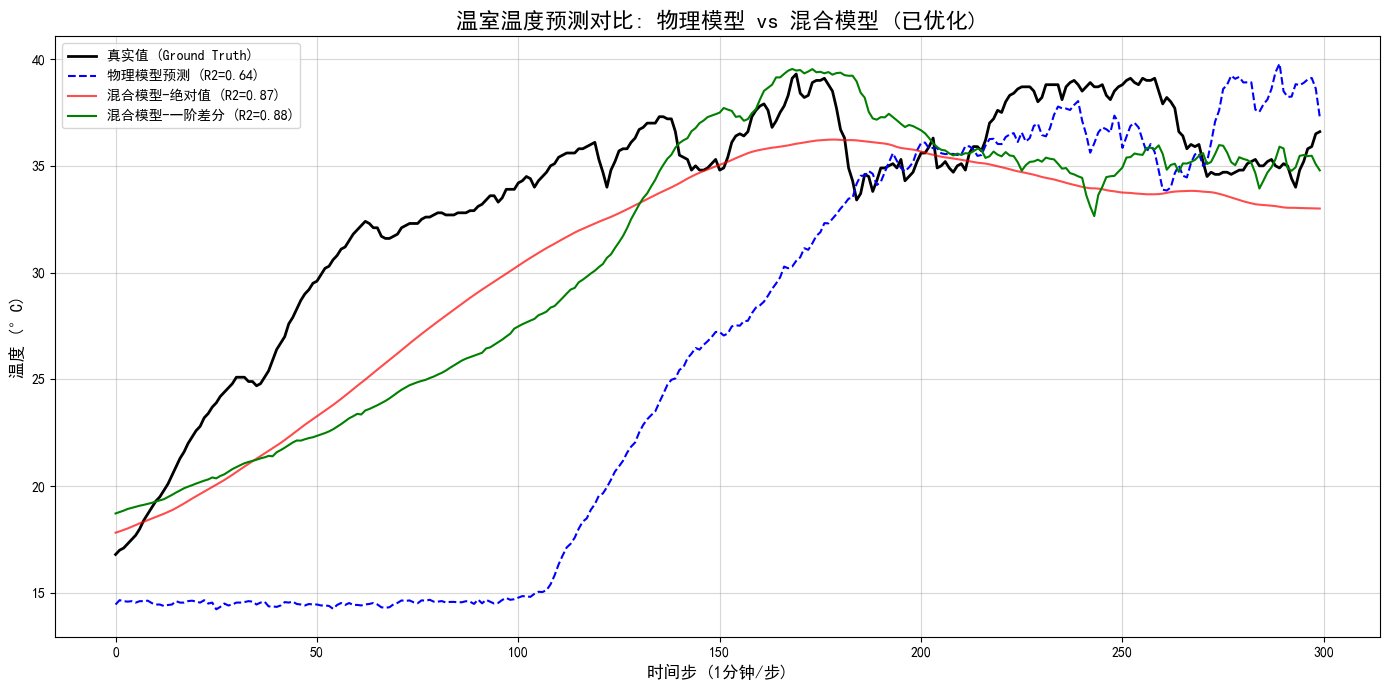


--- 结论分析 ---
1. 物理模型基于简化的线性假设，其 R2 分数为 0.6350。
2. 混合模型(绝对值方法) R2: 0.8710, MAE: 2.6113
3. 混合模型(一阶差分方法) R2: 0.8819, MAE: 2.5006


In [6]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# === 辅助函数与类定义 (PyTorch) ===
# === [新版] 物理增强模块：Neural ODE 导数提取器 ===
class ODEF(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(ODEF, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(), # Softplus 比 Tanh 更适合拟合非负的物理量变化（如光照）
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, y):
        t_vec = torch.ones_like(y[..., :1]) * t
        cat_input = torch.cat([y, t_vec], dim=-1)
        return self.net(cat_input)

def generate_ode_derivatives(df, target_cols):
    """
    不改变原始数据的值，而是计算每分钟的'物理变化率'作为新特征
    """
    print(f"--> [ODE Pro] 正在计算物理导数特征: {target_cols}...")
    
    # 1. 准备训练数据 (仅使用非空的小时级数据)
    df_clean = df[target_cols].dropna()
    scaler = MinMaxScaler()
    data_np = scaler.fit_transform(df_clean.values)
    
    # 时间归一化 (以小时为单位)
    timestamps = (df_clean.index - df_clean.index[0]).total_seconds() / 3600.0
    t_tensor = torch.FloatTensor(timestamps).reshape(-1, 1)
    y_tensor = torch.FloatTensor(data_np)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t_tensor = t_tensor.to(device)
    y_tensor = y_tensor.to(device)
    
    # 2. 训练 ODE 网络拟合变化趋势
    ode_func = ODEF(input_dim=len(target_cols)).to(device)
    optimizer = torch.optim.Adam(ode_func.parameters(), lr=0.02) # 提高学习率
    
    ode_func.train()
    print("    |-- 正在学习物理动力场 (Training Dynamics)...")
    for epoch in range(300): # 增加迭代次数以捕捉细节
        optimizer.zero_grad()
        # 拟合目标：使得模型预测的导数 接近于 真实数据的差分
        # (y_{t+1} - y_t) / dt ~ f(t, y)
        dy_dt_target = (y_tensor[1:] - y_tensor[:-1]) / (t_tensor[1:] - t_tensor[:-1])
        t_mid = (t_tensor[1:] + t_tensor[:-1]) / 2
        y_mid = (y_tensor[1:] + y_tensor[:-1]) / 2
        
        pred_dy_dt = ode_func(t_mid, y_mid)
        loss = torch.mean((pred_dy_dt - dy_dt_target) ** 2)
        loss.backward()
        optimizer.step()
        
    # 3. 推断：生成每分钟的导数
    ode_func.eval()
    print("    |-- 正在生成分钟级导数特征...")
    
    # 创建完整的分钟级时间轴
    full_index = pd.date_range(start=df_clean.index[0], end=df_clean.index[-1], freq='1min')
    
    # 先对原始数据做简单的线性插值，作为 ODE 的输入状态 y
    # (因为我们需要知道当前大概是多少度，才能算出当前的变化率)
    df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')
    y_interp_np = scaler.transform(df_linear_temp.values)
    y_interp_tensor = torch.FloatTensor(y_interp_np).to(device)
    
    t_full_seconds = (full_index - df_clean.index[0]).total_seconds() / 3600.0
    t_full_tensor = torch.FloatTensor(t_full_seconds).reshape(-1, 1).to(device)
    
    with torch.no_grad():
        # 直接查询网络：在 t 时刻，状态为 y 时，变化率是多少？
        derivs_tensor = ode_func(t_full_tensor, y_interp_tensor)
    
    derivs_np = derivs_tensor.cpu().numpy()
    
    # 反归一化导数 (Scale back derivatives)
    # y = scaler * raw => dy = scaler * draw => draw = dy / scaler
    derivs_restored = derivs_np / (scaler.scale_ + 1e-8)
    
    # 创建 DataFrame，列名加后缀 "_Deriv"
    new_cols = [f"{c}_Deriv" for c in target_cols]
    df_derivs = pd.DataFrame(derivs_restored, index=full_index, columns=new_cols)
    
    return df_derivs

# 创建时间序列数据
def create_sequences(data, seq_length, forecast_horizon, future_indices, target_idx):
    xs_past, xs_future, ys, y_bases = [], [], [], []
    # 确保不越界：数据总长度 - (输入序列长度 + 预测距离)
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # 输入：从 i 开始，取 seq_length 个点
        x_p = data[i:(i + seq_length)]
        # 未来控制序列：从 seq_length 结束开始，取 forecast_horizon 个点
        x_f = data[i + seq_length : i + seq_length + forecast_horizon, future_indices]
        # 任务二：输出整个预测序列 [t+1, ..., t+horizon]
        y = data[i + seq_length : i + seq_length + forecast_horizon, target_idx]
        # 基准值：输入序列的最后一个目标值，用于计算差分
        y_base = data[i + seq_length - 1, target_idx]
        xs_past.append(x_p)
        xs_future.append(x_f)
        ys.append(y)
        y_bases.append(y_base)
    return np.array(xs_past), np.array(xs_future), np.array(ys), np.array(y_bases)

# 2. 对比混合模型 (Complex Past + Simple GRU Future)
class SimpleFutureModel(nn.Module):
    def __init__(self, input_dim, future_dim, forecast_horizon, hidden_dim=32):
        super(SimpleFutureModel, self).__init__()
        # 历史数据处理分支 (CNN + BiGRU + Attention)
        self.past_conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.past_bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.past_attention = nn.Linear(hidden_dim * 2, 1)
       
        # 未来控制序列处理分支 (仅使用单向 GRU)
        self.future_gru = nn.GRU(input_size=future_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
       
        # 融合层：历史特征 (hidden_dim * 2) + 未来特征 (hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2 + hidden_dim, forecast_horizon)
    
    def forward(self, x_past, x_future):
        # 处理历史序列 (Complex)
        x_p = x_past.permute(0, 2, 1)
        x_p = torch.relu(self.past_conv1(x_p))
        x_p = x_p.permute(0, 2, 1)
        gru_out_p, _ = self.past_bigru(x_p)
        weights_p = torch.softmax(self.past_attention(gru_out_p), dim=1)
        attended_p = torch.sum(weights_p * gru_out_p, dim=1)
       
        # 处理未来控制序列 (Simple GRU)
        _, h_n = self.future_gru(x_future)
        future_features = h_n[-1]  # 取最后一个时间步
       
        # 特征融合
        combined = torch.cat([attended_p, future_features], dim=1)
        output = self.fc(combined)
        return output

# 评估指标计算
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return mae, rmse, r2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 步骤 0: 初始设置 ---
filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'
print(f"--- 开始处理文件: '{filename}' ---")

try:
    # --- 步骤 1-3: 数据加载, 清洗, 重采样, 填充 ---
    print("--> 正在加载和预处理数据...")
    df = pd.read_csv(filename, encoding='latin1', sep=';', decimal=',', parse_dates=['Timestamp'], dayfirst=True, index_col='Timestamp')
    
    # === [修复] 全局列名清洗 ===
    # 去除列名中的引号和多余空格，统一命名规范，防止匹配失败
    df.columns = [c.replace('"', '').strip() for c in df.columns]
    print(f"--> 列名已清理: {list(df.columns)}")

    # 修复：在转换为数值之前处理开关量列，防止被 to_numeric 转为 NaN 而丢弃
    cols_to_binary = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    for col in cols_to_binary:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['on', 'yes', '1'] else 0)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    
    # === [修改点] 数据处理逻辑 ===
    print("--> 正在执行基础线性插值...")
    # 1. 基础线性插值 (保留最真实的数据骨架)
    df_resampled = df.resample('1min').mean().interpolate(method='linear').ffill().bfill()
    
    # 2. 生成 ODE 导数特征 (增强物理信息)
    outdoor_cols = [c for c in df.columns if 'Outdoor' in c or 'Solar' in c or 'Wind' in c or 'Illumination' in c]
    
    if outdoor_cols:
        try:
            # 计算导数
            df_derivs = generate_ode_derivatives(df, outdoor_cols)
            
            # 将导数特征合并到主表中
            # 注意：这就增加了特征维度，模型会自动利用这些新信息
            df_resampled = pd.concat([df_resampled, df_derivs], axis=1).dropna()
            
            print(f"--> [成功] 已注入 {len(outdoor_cols)} 个物理导数特征 (后缀 _Deriv)")
            
        except Exception as e:
            print(f"--> [警告] ODE 特征生成失败，仅使用原始数据: {e}")
    
    # === [新增] 能量累积特征 (Energy Accumulation) ===
    # 目的: 让模型感知"加热器开了多久"，解决起步慢/滞后问题
    control_cols = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    existing_control_cols = [c for c in control_cols if c in df_resampled.columns]
    
    if existing_control_cols:
        print(f"--> [Energy] 正在构建能量累积特征 (Window=60min): {existing_control_cols}...")
        for col in existing_control_cols:
            # 计算过去60分钟的累积开启时长 (即能量输入)
            df_resampled[f'{col}_Energy_60m'] = df_resampled[col].rolling(window=60, min_periods=1).sum()
        df_resampled.fillna(0, inplace=True)

    print(f"--> 最终数据维度: {df_resampled.shape}")
except Exception as e:
    print(f"处理数据时发生错误: {e}")
    sys.exit(1)

# --- 步骤 4: 物理基准模型构建 ---
print(f"\n--- 正在构建物理基准模型 ---")
# !!! 关键修改：将预测步长定义提前，确保物理模型和混合模型一致 !!!
# 1小时 = 60分钟 = 60 个 1分钟点
forecast_horizon = 120
print(f"--> 物理模型预测步长设定为: {forecast_horizon} 分钟")

physics_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar']
target_col = 'Temperature, °C'
available_physics_features = [col for col in physics_features if col in df_resampled.columns]

# 准备数据
data = df_resampled[available_physics_features].dropna()
if len(data) < forecast_horizon + 1: sys.exit("错误: 物理模型数据不足。")

# !!! 修正数据切片逻辑 !!!
# 输入 X: 从 0 到 总长度 - horizon
# 输出 y: 从 horizon 到 结尾
# 这样建立了 X_t -> y_{t+60} 的关系
X_physics = data.iloc[:-forecast_horizon].copy()
y_physics = data[target_col].iloc[forecast_horizon:].values

control_features = [col for col in ['Heater', 'Ventilation', 'Lighting'] if col in available_physics_features and col != target_col]

# 使用所有可用的物理特征（包含室外天气等）
feature_columns = available_physics_features

# --- 物理模型增强：加入未来控制量的均值 ---
# 计算未来 forecast_horizon 时间段内的控制变量均值
X_physics_augmented = X_physics.copy()
for col in control_features:
    # rolling(window).mean() 计算的是过去窗口的均值，shift(-window) 将其对齐到未来
    # 这样 X_physics_augmented[t] 就包含了 t 到 t+horizon 期间 heater 的平均开启率
    X_physics_augmented[f'Future_Mean_{col}'] = data[col].rolling(window=forecast_horizon).mean().shift(-forecast_horizon).iloc[:-forecast_horizon]

feature_columns = feature_columns + [f'Future_Mean_{col}' for col in control_features]
X_physics_features = X_physics_augmented[feature_columns].fillna(0).values

train_size = int(len(X_physics) * 0.8)
if train_size == 0: sys.exit("错误: 训练数据不足。")

X_train_phy, X_test_phy = X_physics_features[:train_size], X_physics_features[train_size:]
y_train_phy, y_test_phy = y_physics[:train_size], y_physics[train_size:]

physics_model = LinearRegression()
physics_model.fit(X_train_phy, y_train_phy)
y_pred_phy = physics_model.predict(X_test_phy)
print("---> 物理基准模型训练完成。")

# --- 步骤 5: 混合深度学习模型构建 (PyTorch) ---
print("\n--- 正在构建与训练混合深度学习模型 (PyTorch) ---")

df_hybrid = df_resampled.copy()

# 引入时间位置特征 (Time-of-Day Encoding)
hour_float = df_hybrid.index.hour + df_hybrid.index.minute / 60.0
df_hybrid['Hour_Sin'] = np.sin(2 * np.pi * hour_float / 24.0)
df_hybrid['Hour_Cos'] = np.cos(2 * np.pi * hour_float / 24.0)

input_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Hour_Sin', 'Hour_Cos']
# 自动添加导数特征
input_features += [c for c in df_hybrid.columns if '_Deriv' in c]
# 自动添加能量累积特征
input_features += [c for c in df_hybrid.columns if '_Energy' in c]
available_input_features = [f for f in input_features if f in df_hybrid.columns]
target_index = available_input_features.index(target_col)

# 获取控制变量的索引
control_indices = [available_input_features.index(col) for col in control_features]

# 将时间特征也视为“已知未来”的控制变量
time_indices = [available_input_features.index(col) for col in ['Hour_Sin', 'Hour_Cos'] if col in available_input_features]

# 1. 定义天气列
weather_cols = ['Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Illumination, lx']
weather_indices = [available_input_features.index(col) for col in weather_cols if col in available_input_features]

# 2. 加入未来索引
# 逻辑：未来预测 = f(未来控制 + 未来时间 + 未来天气预报)
future_indices = control_indices + time_indices + weather_indices
print(f"--> 未来特征索引检查: {future_indices} (确认包含了天气列的索引)")

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_hybrid[available_input_features])

# --- 数据集划分 (训练、验证、测试) ---
# --- 参数设置区域 ---
# 假设数据间隔是 5分钟 (df_resampled 是 5min 一行)
# 1. 设置输入窗口：比如看过去 2小时的数据来预测
# 2小时 = 120分钟 = 120 个 1分钟点
sequence_length = 120
print(f"--- 正在构建数据集: 输入过去 {sequence_length} 分钟，预测未来 {forecast_horizon} 分钟 ---")

# 原始训练数据
train_data_full = scaled_features[:train_size]
# 原始测试数据
test_data = scaled_features[train_size:]

# 将原始训练数据进一步划分为训练集和验证集 (80/20)
val_split_index = int(len(train_data_full) * 0.8)
train_data = train_data_full[:val_split_index]
val_data = train_data_full[val_split_index:]

# 创建序列
X_train_past, X_train_future, y_train, y_train_bases = create_sequences(train_data, sequence_length, forecast_horizon, future_indices, target_index)
X_val_past, X_val_future, y_val, y_val_bases = create_sequences(val_data, sequence_length, forecast_horizon, future_indices, target_index)
X_test_past, X_test_future, y_test_scaled, y_test_bases = create_sequences(test_data, sequence_length, forecast_horizon, future_indices, target_index)

if len(X_train_past) == 0 or len(X_val_past) == 0 or len(X_test_past) == 0:
    sys.exit("错误: 创建序列后数据不足以划分训练/验证/测试集。")

# 转换为PyTorch张量
X_train_past_tensor = torch.FloatTensor(X_train_past)
X_train_future_tensor = torch.FloatTensor(X_train_future)
y_train_tensor = torch.FloatTensor(y_train)
y_train_bases_tensor = torch.FloatTensor(y_train_bases).unsqueeze(1)

X_val_past_tensor = torch.FloatTensor(X_val_past)
X_val_future_tensor = torch.FloatTensor(X_val_future)
y_val_tensor = torch.FloatTensor(y_val)
y_val_bases_tensor = torch.FloatTensor(y_val_bases).unsqueeze(1)

X_test_past_tensor = torch.FloatTensor(X_test_past)
X_test_future_tensor = torch.FloatTensor(X_test_future)
y_test_bases_tensor = torch.FloatTensor(y_test_bases).unsqueeze(1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_past_tensor, X_train_future_tensor, y_train_tensor, y_train_bases_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_past_tensor, X_val_future_tensor, y_val_tensor, y_val_bases_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- 模型训练与早停机制 ---
# 新增: 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> 使用设备: {device}")

# --- 训练函数 ---
def train_and_predict(model, model_name, train_loader, val_loader, X_test_p, X_test_f, y_test_bases, scaler, target_idx, feat_cols, available_physics_features, predict_diff=False, lambda_trend=0.5):
    print(f"--> 正在训练 {model_name}...")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs, patience = 200, 10
    best_val_loss, epochs_no_improve = float('inf'), 0
    model_path = f"best_{model_name}.pth"
    
    for epoch in range(num_epochs):
        model.train()
        for b_Xp, b_Xf, b_y, b_base in train_loader:
            b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
            optimizer.zero_grad()
           
            pred = model(b_Xp, b_Xf)
            # 如果是差分模式，目标是 (未来值 - 当前基准值)
            target = (b_y - b_base) if predict_diff else b_y
           
            # 基础 MSE 损失
            loss_mse = criterion(pred, target)
           
            # 任务三：趋势惩罚 (Gradient Penalty)
            # 计算预测序列和目标序列的变化率（一阶差分）
            pred_diff = pred[:, 1:] - pred[:, :-1]
            target_diff = target[:, 1:] - target[:, :-1]
            loss_trend = criterion(pred_diff, target_diff)
           
            loss = loss_mse + lambda_trend * loss_trend
            loss.backward()
            optimizer.step()
       
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for b_Xp, b_Xf, b_y, b_base in val_loader:
                b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
                target = (b_y - b_base) if predict_diff else b_y
                val_loss += criterion(model(b_Xp, b_Xf), target).item()  # 验证集仅观察 MSE
       
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience: break
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        pred_tensor = model(X_test_p.to(device), X_test_f.to(device))
        # 仅取序列的最后一个点进行最终评估（对应 t+horizon）
        pred_final = pred_tensor[:, -1].unsqueeze(1)
       
        # 如果是差分模式，还原绝对值：预测的变化量 + 测试集基准值
        if predict_diff:
            pred_final = pred_final + torch.FloatTensor(y_test_bases).to(device).unsqueeze(1)
   
    pred_np = pred_final.cpu().numpy()
    dummy = np.zeros((len(pred_np), len(feat_cols)))
    dummy[:, target_idx] = pred_np.ravel()
    os.remove(model_path)
    return scaler.inverse_transform(dummy)[:, target_idx]

input_dim, future_dim = X_train_past_tensor.shape[2], len(future_indices)

# 实例化两个模型
model_abs = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)
model_diff = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)

# 1. 训练原方法（预测绝对值）
y_pred_abs = train_and_predict(model_abs, "混合模型(绝对值)", train_loader, val_loader,
                               X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=False)

# 2. 训练新方法（预测一阶差分）
y_pred_diff = train_and_predict(model_diff, "混合模型(一阶差分)", train_loader, val_loader,
                                X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=True)

# 获取真实值
dummy_true = np.zeros((len(y_test_scaled), len(available_input_features)))
dummy_true[:, target_index] = y_test_scaled[:, -1].ravel()  # 取序列最后一个点
y_test_hybrid = scaler.inverse_transform(dummy_true)[:, target_index]

# --- 步骤 6: 评估与可视化 ---
print("\n--- 性能对比 ---")

start_offset = sequence_length
end_offset = start_offset + len(y_test_hybrid)
y_test_phy_aligned = y_test_phy[start_offset:end_offset]
y_pred_phy_aligned = y_pred_phy[start_offset:end_offset]

min_len = min(len(y_test_hybrid), len(y_test_phy_aligned))

m1 = calculate_metrics(y_test_phy_aligned[:min_len], y_pred_phy_aligned[:min_len], "基准: 物理微分方程模型")
m2 = calculate_metrics(y_test_hybrid[:min_len], y_pred_abs[:min_len], "本文: 混合模型(绝对值)")
m3 = calculate_metrics(y_test_hybrid[:min_len], y_pred_diff[:min_len], "本文: 混合模型(一阶差分)")

plt.figure(figsize=(14, 7))
plot_len = min(300, min_len)
plt.plot(y_test_phy_aligned[:plot_len], label='真实值 (Ground Truth)', color='black', linewidth=2)
plt.plot(y_pred_phy_aligned[:plot_len], label=f'物理模型预测 (R2={m1[2]:.2f})', color='blue', linestyle='--')
plt.plot(y_pred_abs[:plot_len], label=f'混合模型-绝对值 (R2={m2[2]:.2f})', color='red', linewidth=1.5, alpha=0.7)
plt.plot(y_pred_diff[:plot_len], label=f'混合模型-一阶差分 (R2={m3[2]:.2f})', color='green', linewidth=1.5)
plt.title(f"温室温度预测对比: 物理模型 vs 混合模型 (已优化)", fontsize=16)
plt.xlabel("时间步 (1分钟/步)", fontsize=12)
plt.ylabel("温度 (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- 步骤 7: 输出结论文本 ---
print("\n--- 结论分析 ---")
print(f"1. 物理模型基于简化的线性假设，其 R2 分数为 {m1[2]:.4f}。")
print(f"2. 混合模型(绝对值方法) R2: {m2[2]:.4f}, MAE: {m2[0]:.4f}")
print(f"3. 混合模型(一阶差分方法) R2: {m3[2]:.4f}, MAE: {m3[0]:.4f}")

--- 开始处理文件: 'Strawberry Greenhouse Environmental Control Dataset(version2).csv' ---
--> 正在加载和预处理数据...
--> 列名已清理: ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Pressure, MPa', 'Solution temperature, °C', 'Solution acidity, pH', 'Solution conductivity, ?S/cm', 'Heater', 'Lighting', 'Ventilation', 'Air circulation', 'Ground', 'Fog', 'Pump 1', 'Pump 2', 'Valve 1', 'Valve 2', 'Battery, V', 'Vcc, V', 'Version']
--> 正在执行基础线性插值...
--> [ODE Pro] 正在计算物理导数特征: ['Illumination, lx']...
    |-- 正在学习物理动力场 (Training Dynamics)...
    |-- 正在生成分钟级导数特征...
--> [成功] 已注入 1 个物理导数特征 (后缀 _Deriv)
--> [Energy] 正在构建能量累积特征 (Window=60min): ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']...
--> 最终数据维度: (31704, 21)

--- 正在构建物理基准模型 ---
--> 物理模型预测步长设定为: 120 分钟
---> 物理基准模型训练完成。

--- 正在构建与训练混合深度学习模型 (PyTorch) ---
--> 未来特征索引检查: [4, 5, 6, 7, 8, 2] (确认包含了天气列的索引)
--- 正在构建数据集: 输入过去 120 分钟，预测未来 120 分钟 ---


C:\Users\wokis\AppData\Local\Temp\ipykernel_30740\319249058.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')


--> 使用设备: cuda
--> 正在训练 混合模型(绝对值)...
--> 正在训练 混合模型(一阶差分)...

--- 性能对比 ---
[基准: 物理微分方程模型] MAE: 3.8811, RMSE: 5.6919, R2: 0.6350
[本文: 混合模型(绝对值)] MAE: 2.3790, RMSE: 3.1328, R2: 0.8894
[本文: 混合模型(一阶差分)] MAE: 2.2949, RMSE: 3.0442, R2: 0.8956


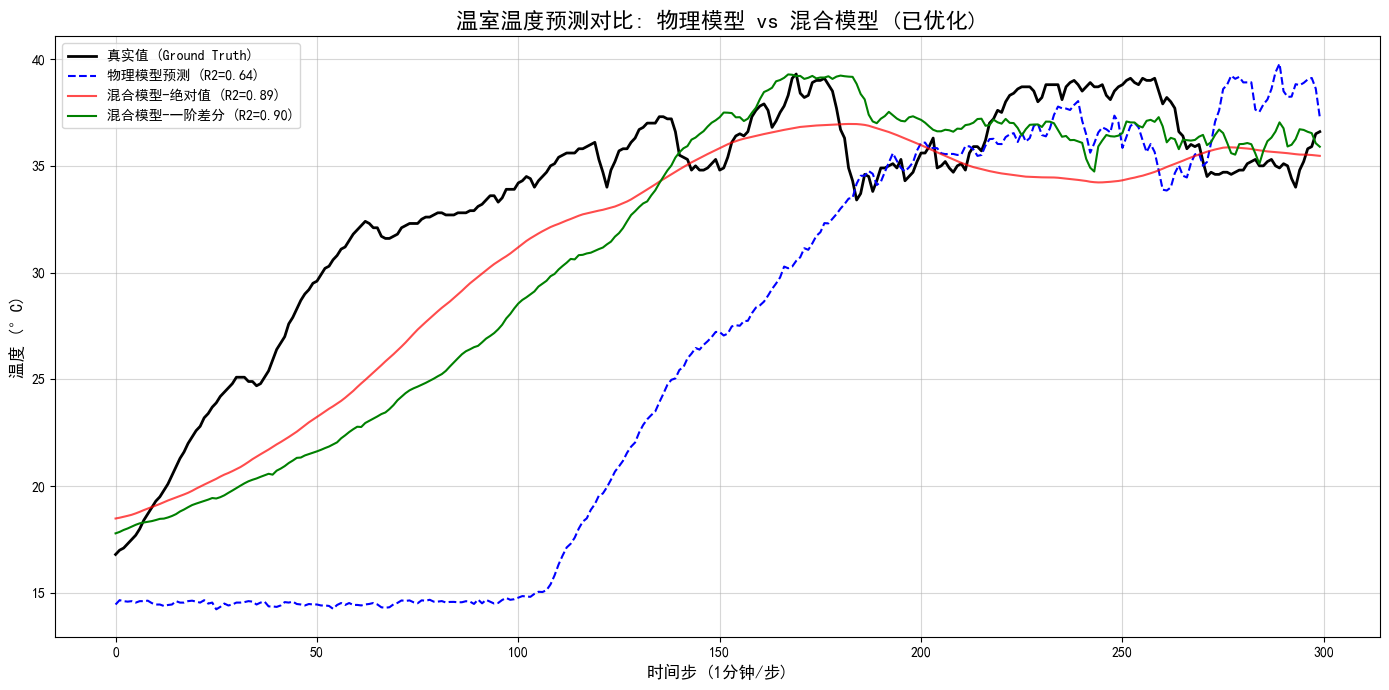


--- 结论分析 ---
1. 物理模型基于简化的线性假设，其 R2 分数为 0.6350。
2. 混合模型(绝对值方法) R2: 0.8894, MAE: 2.3790
3. 混合模型(一阶差分方法) R2: 0.8956, MAE: 2.2949


In [7]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# === 辅助函数与类定义 (PyTorch) ===
# === [新版] 物理增强模块：Neural ODE 导数提取器 ===
class ODEF(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(ODEF, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(), # Softplus 比 Tanh 更适合拟合非负的物理量变化（如光照）
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, y):
        t_vec = torch.ones_like(y[..., :1]) * t
        cat_input = torch.cat([y, t_vec], dim=-1)
        return self.net(cat_input)

def generate_ode_derivatives(df, target_cols):
    """
    不改变原始数据的值，而是计算每分钟的'物理变化率'作为新特征
    """
    print(f"--> [ODE Pro] 正在计算物理导数特征: {target_cols}...")
    
    # 1. 准备训练数据 (仅使用非空的小时级数据)
    df_clean = df[target_cols].dropna()
    scaler = MinMaxScaler()
    data_np = scaler.fit_transform(df_clean.values)
    
    # 时间归一化 (以小时为单位)
    timestamps = (df_clean.index - df_clean.index[0]).total_seconds() / 3600.0
    t_tensor = torch.FloatTensor(timestamps).reshape(-1, 1)
    y_tensor = torch.FloatTensor(data_np)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t_tensor = t_tensor.to(device)
    y_tensor = y_tensor.to(device)
    
    # 2. 训练 ODE 网络拟合变化趋势
    ode_func = ODEF(input_dim=len(target_cols)).to(device)
    optimizer = torch.optim.Adam(ode_func.parameters(), lr=0.02) # 提高学习率
    
    ode_func.train()
    print("    |-- 正在学习物理动力场 (Training Dynamics)...")
    for epoch in range(300): # 增加迭代次数以捕捉细节
        optimizer.zero_grad()
        # 拟合目标：使得模型预测的导数 接近于 真实数据的差分
        # (y_{t+1} - y_t) / dt ~ f(t, y)
        dy_dt_target = (y_tensor[1:] - y_tensor[:-1]) / (t_tensor[1:] - t_tensor[:-1])
        t_mid = (t_tensor[1:] + t_tensor[:-1]) / 2
        y_mid = (y_tensor[1:] + y_tensor[:-1]) / 2
        
        pred_dy_dt = ode_func(t_mid, y_mid)
        loss = torch.mean((pred_dy_dt - dy_dt_target) ** 2)
        loss.backward()
        optimizer.step()
        
    # 3. 推断：生成每分钟的导数
    ode_func.eval()
    print("    |-- 正在生成分钟级导数特征...")
    
    # 创建完整的分钟级时间轴
    full_index = pd.date_range(start=df_clean.index[0], end=df_clean.index[-1], freq='1min')
    
    # 先对原始数据做简单的线性插值，作为 ODE 的输入状态 y
    # (因为我们需要知道当前大概是多少度，才能算出当前的变化率)
    df_linear_temp = df[target_cols].reindex(full_index).interpolate(method='linear').fillna(method='bfill')
    y_interp_np = scaler.transform(df_linear_temp.values)
    y_interp_tensor = torch.FloatTensor(y_interp_np).to(device)
    
    t_full_seconds = (full_index - df_clean.index[0]).total_seconds() / 3600.0
    t_full_tensor = torch.FloatTensor(t_full_seconds).reshape(-1, 1).to(device)
    
    with torch.no_grad():
        # 直接查询网络：在 t 时刻，状态为 y 时，变化率是多少？
        derivs_tensor = ode_func(t_full_tensor, y_interp_tensor)
    
    derivs_np = derivs_tensor.cpu().numpy()
    
    # 反归一化导数 (Scale back derivatives)
    # y = scaler * raw => dy = scaler * draw => draw = dy / scaler
    derivs_restored = derivs_np / (scaler.scale_ + 1e-8)
    
    # 创建 DataFrame，列名加后缀 "_Deriv"
    new_cols = [f"{c}_Deriv" for c in target_cols]
    df_derivs = pd.DataFrame(derivs_restored, index=full_index, columns=new_cols)
    
    return df_derivs

# 创建时间序列数据
def create_sequences(data, seq_length, forecast_horizon, future_indices, target_idx):
    xs_past, xs_future, ys, y_bases = [], [], [], []
    # 确保不越界：数据总长度 - (输入序列长度 + 预测距离)
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # 输入：从 i 开始，取 seq_length 个点
        x_p = data[i:(i + seq_length)]
        # 未来控制序列：从 seq_length 结束开始，取 forecast_horizon 个点
        x_f = data[i + seq_length : i + seq_length + forecast_horizon, future_indices]
        # 任务二：输出整个预测序列 [t+1, ..., t+horizon]
        y = data[i + seq_length : i + seq_length + forecast_horizon, target_idx]
        # 基准值：输入序列的最后一个目标值，用于计算差分
        y_base = data[i + seq_length - 1, target_idx]
        xs_past.append(x_p)
        xs_future.append(x_f)
        ys.append(y)
        y_bases.append(y_base)
    return np.array(xs_past), np.array(xs_future), np.array(ys), np.array(y_bases)

# 2. 对比混合模型 (Complex Past + Simple GRU Future)
class SimpleFutureModel(nn.Module):
    def __init__(self, input_dim, future_dim, forecast_horizon, hidden_dim=32):
        super(SimpleFutureModel, self).__init__()
        # 历史数据处理分支 (CNN + BiGRU + Attention)
        self.past_conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.past_bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.past_attention = nn.Linear(hidden_dim * 2, 1)
       
        # 未来控制序列处理分支 (仅使用单向 GRU)
        self.future_gru = nn.GRU(input_size=future_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
       
        # 融合层：历史特征 (hidden_dim * 2) + 未来特征 (hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2 + hidden_dim, forecast_horizon)
    
    def forward(self, x_past, x_future):
        # 处理历史序列 (Complex)
        x_p = x_past.permute(0, 2, 1)
        x_p = torch.relu(self.past_conv1(x_p))
        x_p = x_p.permute(0, 2, 1)
        gru_out_p, _ = self.past_bigru(x_p)
        weights_p = torch.softmax(self.past_attention(gru_out_p), dim=1)
        attended_p = torch.sum(weights_p * gru_out_p, dim=1)
       
        # 处理未来控制序列 (Simple GRU)
        _, h_n = self.future_gru(x_future)
        future_features = h_n[-1]  # 取最后一个时间步
       
        # 特征融合
        combined = torch.cat([attended_p, future_features], dim=1)
        output = self.fc(combined)
        return output

# 评估指标计算
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return mae, rmse, r2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 步骤 0: 初始设置 ---
filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'
print(f"--- 开始处理文件: '{filename}' ---")

try:
    # --- 步骤 1-3: 数据加载, 清洗, 重采样, 填充 ---
    print("--> 正在加载和预处理数据...")
    df = pd.read_csv(filename, encoding='latin1', sep=';', decimal=',', parse_dates=['Timestamp'], dayfirst=True, index_col='Timestamp')
    
    # === [修复] 全局列名清洗 ===
    # 去除列名中的引号和多余空格，统一命名规范，防止匹配失败
    df.columns = [c.replace('"', '').strip() for c in df.columns]
    print(f"--> 列名已清理: {list(df.columns)}")

    # 修复：在转换为数值之前处理开关量列，防止被 to_numeric 转为 NaN 而丢弃
    cols_to_binary = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    for col in cols_to_binary:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['on', 'yes', '1'] else 0)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    
    # === [修改点] 数据处理逻辑 ===
    print("--> 正在执行基础线性插值...")
    # 1. 基础线性插值 (保留最真实的数据骨架)
    df_resampled = df.resample('1min').mean().interpolate(method='linear').ffill().bfill()
    
    # 2. 生成 ODE 导数特征 (增强物理信息)
    outdoor_cols = [c for c in df.columns if 'Outdoor' in c or 'Solar' in c or 'Wind' in c or 'Illumination' in c]
    
    if outdoor_cols:
        try:
            # 计算导数
            df_derivs = generate_ode_derivatives(df, outdoor_cols)
            
            # 将导数特征合并到主表中
            # 注意：这就增加了特征维度，模型会自动利用这些新信息
            df_resampled = pd.concat([df_resampled, df_derivs], axis=1).dropna()
            
            print(f"--> [成功] 已注入 {len(outdoor_cols)} 个物理导数特征 (后缀 _Deriv)")
            
        except Exception as e:
            print(f"--> [警告] ODE 特征生成失败，仅使用原始数据: {e}")
    
    # === [新增] 能量累积特征 (Energy Accumulation) ===
    # 目的: 让模型感知"加热器开了多久"，解决起步慢/滞后问题
    control_cols = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    existing_control_cols = [c for c in control_cols if c in df_resampled.columns]
    
    if existing_control_cols:
        print(f"--> [Energy] 正在构建能量累积特征 (Window=60min): {existing_control_cols}...")
        for col in existing_control_cols:
            # 计算过去60分钟的累积开启时长 (即能量输入)
            df_resampled[f'{col}_Energy_60m'] = df_resampled[col].rolling(window=60, min_periods=1).sum()
        df_resampled.fillna(0, inplace=True)

    print(f"--> 最终数据维度: {df_resampled.shape}")
except Exception as e:
    print(f"处理数据时发生错误: {e}")
    sys.exit(1)

# --- 步骤 4: 物理基准模型构建 ---
print(f"\n--- 正在构建物理基准模型 ---")
# !!! 关键修改：将预测步长定义提前，确保物理模型和混合模型一致 !!!
# 1小时 = 60分钟 = 60 个 1分钟点
forecast_horizon = 120
print(f"--> 物理模型预测步长设定为: {forecast_horizon} 分钟")

physics_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar']
target_col = 'Temperature, °C'
available_physics_features = [col for col in physics_features if col in df_resampled.columns]

# 准备数据
data = df_resampled[available_physics_features].dropna()
if len(data) < forecast_horizon + 1: sys.exit("错误: 物理模型数据不足。")

# !!! 修正数据切片逻辑 !!!
# 输入 X: 从 0 到 总长度 - horizon
# 输出 y: 从 horizon 到 结尾
# 这样建立了 X_t -> y_{t+60} 的关系
X_physics = data.iloc[:-forecast_horizon].copy()
y_physics = data[target_col].iloc[forecast_horizon:].values

control_features = [col for col in ['Heater', 'Ventilation', 'Lighting'] if col in available_physics_features and col != target_col]

# 使用所有可用的物理特征（包含室外天气等）
feature_columns = available_physics_features

# --- 物理模型增强：加入未来控制量的均值 ---
# 计算未来 forecast_horizon 时间段内的控制变量均值
X_physics_augmented = X_physics.copy()
for col in control_features:
    # rolling(window).mean() 计算的是过去窗口的均值，shift(-window) 将其对齐到未来
    # 这样 X_physics_augmented[t] 就包含了 t 到 t+horizon 期间 heater 的平均开启率
    X_physics_augmented[f'Future_Mean_{col}'] = data[col].rolling(window=forecast_horizon).mean().shift(-forecast_horizon).iloc[:-forecast_horizon]

feature_columns = feature_columns + [f'Future_Mean_{col}' for col in control_features]
X_physics_features = X_physics_augmented[feature_columns].fillna(0).values

train_size = int(len(X_physics) * 0.8)
if train_size == 0: sys.exit("错误: 训练数据不足。")

X_train_phy, X_test_phy = X_physics_features[:train_size], X_physics_features[train_size:]
y_train_phy, y_test_phy = y_physics[:train_size], y_physics[train_size:]

physics_model = LinearRegression()
physics_model.fit(X_train_phy, y_train_phy)
y_pred_phy = physics_model.predict(X_test_phy)
print("---> 物理基准模型训练完成。")

# --- 步骤 5: 混合深度学习模型构建 (PyTorch) ---
print("\n--- 正在构建与训练混合深度学习模型 (PyTorch) ---")

df_hybrid = df_resampled.copy()

# 引入时间位置特征 (Time-of-Day Encoding)
hour_float = df_hybrid.index.hour + df_hybrid.index.minute / 60.0
df_hybrid['Hour_Sin'] = np.sin(2 * np.pi * hour_float / 24.0)
df_hybrid['Hour_Cos'] = np.cos(2 * np.pi * hour_float / 24.0)

input_features = ['Temperature, °C', 'Humidity, %', 'Illumination, lx', 'CO?, ppm', 'Heater', 'Ventilation', 'Lighting', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Hour_Sin', 'Hour_Cos']
# 自动添加导数特征
input_features += [c for c in df_hybrid.columns if '_Deriv' in c]
# 自动添加能量累积特征
input_features += [c for c in df_hybrid.columns if '_Energy' in c]
available_input_features = [f for f in input_features if f in df_hybrid.columns]
target_index = available_input_features.index(target_col)

# 获取控制变量的索引
control_indices = [available_input_features.index(col) for col in control_features]

# 将时间特征也视为“已知未来”的控制变量
time_indices = [available_input_features.index(col) for col in ['Hour_Sin', 'Hour_Cos'] if col in available_input_features]

# 1. 定义天气列
weather_cols = ['Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Illumination, lx']
weather_indices = [available_input_features.index(col) for col in weather_cols if col in available_input_features]

# 2. 加入未来索引
# 逻辑：未来预测 = f(未来控制 + 未来时间 + 未来天气预报)
future_indices = control_indices + time_indices + weather_indices
print(f"--> 未来特征索引检查: {future_indices} (确认包含了天气列的索引)")

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_hybrid[available_input_features])

# --- 数据集划分 (训练、验证、测试) ---
# --- 参数设置区域 ---
# 假设数据间隔是 5分钟 (df_resampled 是 5min 一行)
# 1. 设置输入窗口：比如看过去 2小时的数据来预测
# 2小时 = 120分钟 = 120 个 1分钟点
sequence_length = 120
print(f"--- 正在构建数据集: 输入过去 {sequence_length} 分钟，预测未来 {forecast_horizon} 分钟 ---")

# 原始训练数据
train_data_full = scaled_features[:train_size]
# 原始测试数据
test_data = scaled_features[train_size:]

# 将原始训练数据进一步划分为训练集和验证集 (80/20)
val_split_index = int(len(train_data_full) * 0.8)
train_data = train_data_full[:val_split_index]
val_data = train_data_full[val_split_index:]

# 创建序列
X_train_past, X_train_future, y_train, y_train_bases = create_sequences(train_data, sequence_length, forecast_horizon, future_indices, target_index)
X_val_past, X_val_future, y_val, y_val_bases = create_sequences(val_data, sequence_length, forecast_horizon, future_indices, target_index)
X_test_past, X_test_future, y_test_scaled, y_test_bases = create_sequences(test_data, sequence_length, forecast_horizon, future_indices, target_index)

if len(X_train_past) == 0 or len(X_val_past) == 0 or len(X_test_past) == 0:
    sys.exit("错误: 创建序列后数据不足以划分训练/验证/测试集。")

# 转换为PyTorch张量
X_train_past_tensor = torch.FloatTensor(X_train_past)
X_train_future_tensor = torch.FloatTensor(X_train_future)
y_train_tensor = torch.FloatTensor(y_train)
y_train_bases_tensor = torch.FloatTensor(y_train_bases).unsqueeze(1)

X_val_past_tensor = torch.FloatTensor(X_val_past)
X_val_future_tensor = torch.FloatTensor(X_val_future)
y_val_tensor = torch.FloatTensor(y_val)
y_val_bases_tensor = torch.FloatTensor(y_val_bases).unsqueeze(1)

X_test_past_tensor = torch.FloatTensor(X_test_past)
X_test_future_tensor = torch.FloatTensor(X_test_future)
y_test_bases_tensor = torch.FloatTensor(y_test_bases).unsqueeze(1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_past_tensor, X_train_future_tensor, y_train_tensor, y_train_bases_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_past_tensor, X_val_future_tensor, y_val_tensor, y_val_bases_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- 模型训练与早停机制 ---
# 新增: 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> 使用设备: {device}")

# --- 训练函数 ---
def train_and_predict(model, model_name, train_loader, val_loader, X_test_p, X_test_f, y_test_bases, scaler, target_idx, feat_cols, available_physics_features, predict_diff=False, lambda_trend=0.5):
    print(f"--> 正在训练 {model_name}...")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs, patience = 200, 10
    best_val_loss, epochs_no_improve = float('inf'), 0
    model_path = f"best_{model_name}.pth"
    
    for epoch in range(num_epochs):
        model.train()
        for b_Xp, b_Xf, b_y, b_base in train_loader:
            b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
            optimizer.zero_grad()
           
            pred = model(b_Xp, b_Xf)
            # 如果是差分模式，目标是 (未来值 - 当前基准值)
            target = (b_y - b_base) if predict_diff else b_y
           
            # 基础 MSE 损失
            loss_mse = criterion(pred, target)
           
            # 任务三：趋势惩罚 (Gradient Penalty)
            # 计算预测序列和目标序列的变化率（一阶差分）
            pred_diff = pred[:, 1:] - pred[:, :-1]
            target_diff = target[:, 1:] - target[:, :-1]
            loss_trend = criterion(pred_diff, target_diff)
           
            loss = loss_mse + lambda_trend * loss_trend
            loss.backward()
            optimizer.step()
       
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for b_Xp, b_Xf, b_y, b_base in val_loader:
                b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
                target = (b_y - b_base) if predict_diff else b_y
                val_loss += criterion(model(b_Xp, b_Xf), target).item()  # 验证集仅观察 MSE
       
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience: break
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        pred_tensor = model(X_test_p.to(device), X_test_f.to(device))
        # 仅取序列的最后一个点进行最终评估（对应 t+horizon）
        pred_final = pred_tensor[:, -1].unsqueeze(1)
       
        # 如果是差分模式，还原绝对值：预测的变化量 + 测试集基准值
        if predict_diff:
            pred_final = pred_final + torch.FloatTensor(y_test_bases).to(device).unsqueeze(1)
   
    pred_np = pred_final.cpu().numpy()
    dummy = np.zeros((len(pred_np), len(feat_cols)))
    dummy[:, target_idx] = pred_np.ravel()
    os.remove(model_path)
    return scaler.inverse_transform(dummy)[:, target_idx]

input_dim, future_dim = X_train_past_tensor.shape[2], len(future_indices)

# 实例化两个模型
model_abs = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)
model_diff = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)

# 1. 训练原方法（预测绝对值）
y_pred_abs = train_and_predict(model_abs, "混合模型(绝对值)", train_loader, val_loader,
                               X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=False)

# 2. 训练新方法（预测一阶差分）
y_pred_diff = train_and_predict(model_diff, "混合模型(一阶差分)", train_loader, val_loader,
                                X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=True)

# 获取真实值
dummy_true = np.zeros((len(y_test_scaled), len(available_input_features)))
dummy_true[:, target_index] = y_test_scaled[:, -1].ravel()  # 取序列最后一个点
y_test_hybrid = scaler.inverse_transform(dummy_true)[:, target_index]

# --- 步骤 6: 评估与可视化 ---
print("\n--- 性能对比 ---")

start_offset = sequence_length
end_offset = start_offset + len(y_test_hybrid)
y_test_phy_aligned = y_test_phy[start_offset:end_offset]
y_pred_phy_aligned = y_pred_phy[start_offset:end_offset]

min_len = min(len(y_test_hybrid), len(y_test_phy_aligned))

m1 = calculate_metrics(y_test_phy_aligned[:min_len], y_pred_phy_aligned[:min_len], "基准: 物理微分方程模型")
m2 = calculate_metrics(y_test_hybrid[:min_len], y_pred_abs[:min_len], "本文: 混合模型(绝对值)")
m3 = calculate_metrics(y_test_hybrid[:min_len], y_pred_diff[:min_len], "本文: 混合模型(一阶差分)")

plt.figure(figsize=(14, 7))
plot_len = min(300, min_len)
plt.plot(y_test_phy_aligned[:plot_len], label='真实值 (Ground Truth)', color='black', linewidth=2)
plt.plot(y_pred_phy_aligned[:plot_len], label=f'物理模型预测 (R2={m1[2]:.2f})', color='blue', linestyle='--')
plt.plot(y_pred_abs[:plot_len], label=f'混合模型-绝对值 (R2={m2[2]:.2f})', color='red', linewidth=1.5, alpha=0.7)
plt.plot(y_pred_diff[:plot_len], label=f'混合模型-一阶差分 (R2={m3[2]:.2f})', color='green', linewidth=1.5)
plt.title(f"温室温度预测对比: 物理模型 vs 混合模型 (已优化)", fontsize=16)
plt.xlabel("时间步 (1分钟/步)", fontsize=12)
plt.ylabel("温度 (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- 步骤 7: 输出结论文本 ---
print("\n--- 结论分析 ---")
print(f"1. 物理模型基于简化的线性假设，其 R2 分数为 {m1[2]:.4f}。")
print(f"2. 混合模型(绝对值方法) R2: {m2[2]:.4f}, MAE: {m2[0]:.4f}")
print(f"3. 混合模型(一阶差分方法) R2: {m3[2]:.4f}, MAE: {m3[0]:.4f}")